In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scipy
print(scipy.__version__)
print(matplotlib.__version__)
import scipy.special as sci_spe
from scipy.stats import qmc
from time import time


1.11.3
3.8.0


# Simulation parameters

In [2]:
N = 200                   # Grid size
maximum_length = 300      # Correlation length for water vapor density (m)
h = 4869                  # Height for QUBIC (m)
L = 5000                  # Atm size (m)
Lz = 1000                 # Atm depth (m)
L_QUBIC = h * np.sin(np.radians(15)) 

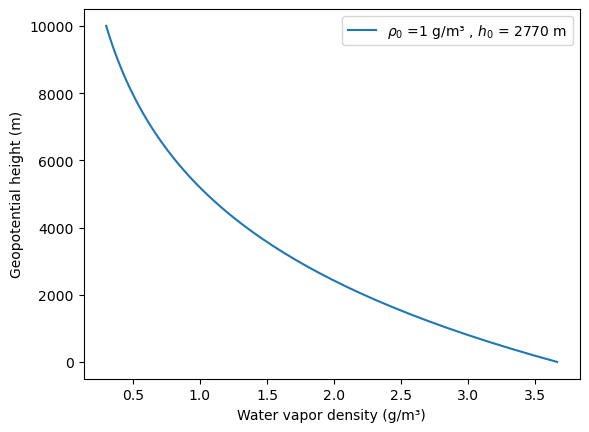

In [3]:
# Mean water vapor density as a function of height

def water_vapor_density(z, rho_0=1, h0=1000):
    '''
    Water vapor density as a function of geopotential height h
    rho_0: Reference mean density of water vapor in g/m³
    h0: The half height for water vapor in m
    '''
    return rho_0 * np.exp(-np.log(2) * (z - 5190) / h0)
 
water_vapor_0 = water_vapor_density(h, 1, 1000)

z = np.linspace(0, 10000)
rho_0 = 1
h0 = 2770 
plt.plot(water_vapor_density(z, rho_0, h0), z, label=r'$\rho_0$ =' + f'{rho_0} g/m³ , ' + r'$h_0$ = ' + f'{h0} m')
plt.xlabel('Water vapor density (g/m³)')
plt.ylabel('Geopotential height (m)')
plt.legend()
plt.show()

# Simulation of the fluctuations of the water vapor density

In [4]:
# Generate spatial frequency in Fourier space
k_distrib = np.fft.fftfreq(N, d=2*L/N) * 2*np.pi
kx, ky, kz = np.meshgrid(k_distrib, k_distrib, k_distrib)
k_mag = np.sqrt(kx**2 + ky**2 + kz**2)

In [5]:
# We will use the Kolomogorov power spectrum to simulate turbulences in atmosphere
def kolmogorov_spectra(k):
    return (maximum_length**(-2) + np.abs(k)**2)**(-11/6)

# We normalize to have the integral of the power spectrum over all k egal to 1
res, _ = scipy.integrate.quad(kolmogorov_spectra, np.min(k_mag), np.max(k_mag))
def normalized_kolmogorov(k):  
    return kolmogorov_spectra(k)/res

print(scipy.integrate.quad(normalized_kolmogorov, np.min(k_mag), np.max(k_mag))[0])

1.0000000000000002


In [6]:
# Compute the Kolmogorov power spectrum 
P_k = normalized_kolmogorov(k_mag)

# Generate spatial fluctuations using the spatial power spectrum
phi = np.random.uniform(0, 2*np.pi, size=(N, N, N))
delta_rho_k = np.sqrt(P_k) * np.exp(1j * phi)

# Apply inverse Fourier transform to obtain spatial fluctuations
delta_rho = np.fft.ifftn(delta_rho_k).real

We need to normalize these simulation to match the mean water vapor
density as a function of height. And we also need to fit the variance of
the fluctuations.

For this we know the variance of precipitable water vapor (PWV)
$\sigma^2_{PWV}$. The PWV is the integral of water vapor density along
the atmosphere colomn: $PWV = \int_h\rho(h)dh$.

We will assume that the RMS of the water vapor density at height $z$ is
proportionnal to it’s mean value:
$\sigma_{\rho(h)}\propto \langle \rho(h)\rangle$.

So we assume the simple model:
$$\sigma_{\rho(h)} = \frac{\sigma_{PWV}}{PWV}\langle \rho(h)\rangle.$$

With data given on figure 4 of the article “The Atacama cosmology
telescope: modeling bulk atmospheric motion”, we estimate $\sigma_{PWV}$
to be $0.8 mm^{-1}$ in winter and $2.2 mm^{-1}$ in summer. We take
$\sigma_{PWV} = 1.5 mm^{-1}$ as an order of magnitude.

The RMS of $\rho$ is probably an overestimate but gives a physical idea.

Also we need to take into account that we cut high wavenumbers in our
simulation, this reduces the RMS. Using Parseval’s theorem, we know that
the variance is the integral of the power spectrum:
$\sigma_{\rho}^2 \propto \int_{\mathbb{R}^3}P(\vec{k})d^3\vec{k}=4\pi\int_{\mathbb{R}}P(k)k^2dk$.
So the simulated RMS will be:
$$\sigma_{\text{simulated, }h} = \sqrt{\frac{\int_{\text{min(k distrib)}}^{\text{max(kdistrib)}} P(k)k^2dk}{\int_{\mathbb{R}}P(k)k^2dk}} \sigma_{\rho(h)}$$

In [7]:
PWV = 5 #mm^-1
z = np.linspace(h, h+Lz, N)
mean_water_vapor = water_vapor_density(z)
sigma_PWV = 0.5 #mm^-1
sigma_rho = sigma_PWV / 10 * mean_water_vapor

# Takes into account the cutoff of high wavenumbers
sigma_simulated = sigma_rho * np.sqrt(scipy.integrate.quad(lambda k : kolmogorov_spectra(k) * k**2, np.min(k_distrib), np.max(k_distrib))[0] 
                                       / scipy.integrate.quad(lambda k : kolmogorov_spectra(k) * k**2, -maximum_length, maximum_length)[0])

rho = np.zeros((N, N, N))

mean_delta = np.mean(delta_rho)
var_delta = np.var(delta_rho)

for i in range(N):
    rho[:, :, i] = mean_water_vapor[i] + sigma_simulated[i] * (delta_rho[:, :, i] - mean_delta) / np.sqrt(var_delta)


7.996565271241478e-05


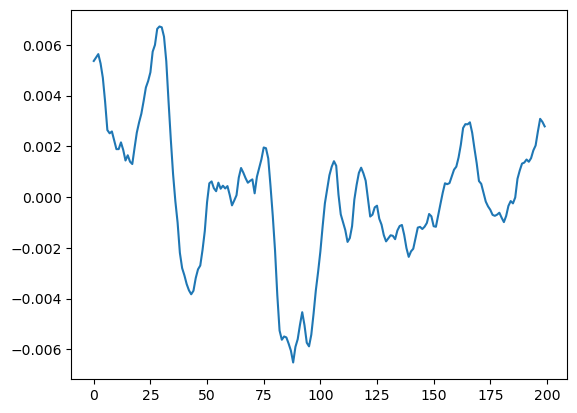

In [8]:
l = []
for i in range(N):
    l.append(np.mean(rho[..., i] - mean_water_vapor[i]))
print(np.mean(l))
plt.plot(l)

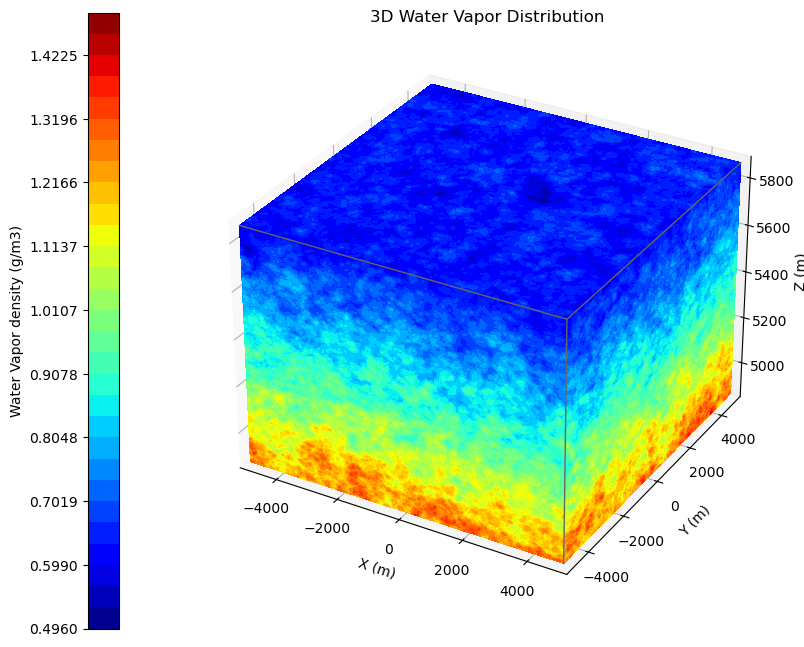

In [9]:
# 3d plot of the fluctuations
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-L, L, N)
y = np.linspace(-L, L, N)
z = np.linspace(h, h+Lz, N)
X, Y, Z = np.meshgrid(x, y, z)

kw = {'vmin': rho.min(),
    'vmax': rho.max(),
    'levels': np.linspace(rho.min(), rho.max(), 30)}

# Plot contour surfaces
ax.contourf(X[:, :, -1], Y[:, :, -1], rho[:, :, -1], zdir='z', offset=Z.max(), cmap='jet', **kw)
ax.contourf(X[0, :, :], rho[0, :, :], Z[0, :, :], zdir='y', offset=Y.min(), cmap='jet', **kw)
C = ax.contourf(rho[:, -1, :], Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), cmap='jet', **kw)

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Water Vapor Distribution')
cbar = fig.colorbar(C, ax=ax, location='left')
#cbar = fig.colorbar(scatter, ax=ax, location='left')
cbar.set_label('Water Vapor density (g/m3)')
plt.show()

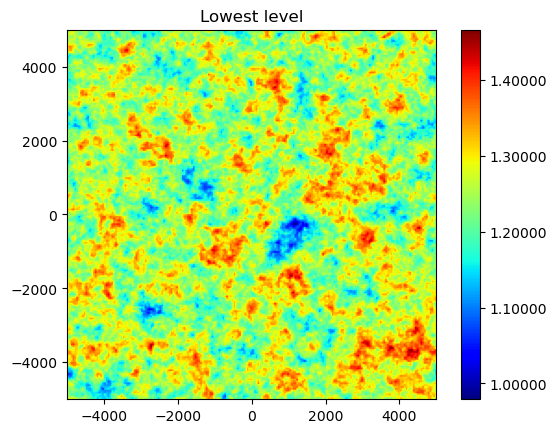

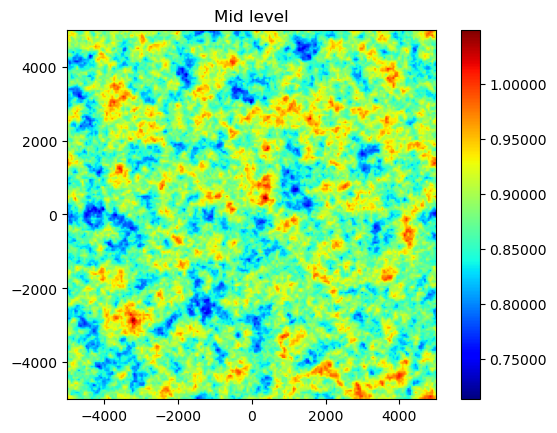

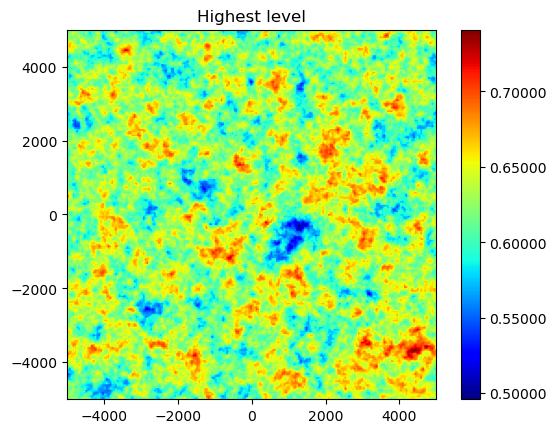

In [10]:
# Plots of horizontal sections
plt.figure()
plt.imshow(rho[:, :, 0], extent=[-L, L, -L, L], cmap='jet')
plt.title('Lowest level')
plt.colorbar(format = '%.5f')
plt.show()

plt.figure()
plt.imshow(rho[:, :, round(N/2)], extent=[-L, L, -L, L], cmap='jet')
plt.title('Mid level')
plt.colorbar(format = '%.5f')
plt.show()

plt.figure()
plt.imshow(rho[:, :, -1], extent=[-L, L, -L, L], cmap='jet')
plt.title('Highest level')
plt.colorbar(format = '%.5f')
plt.show()

# Atmospheric contribution to detectors

In [11]:
z_atm = 40000 # (m), typical height that depends on the observation site, on the order of ~10⁴ m
T_ground = 280 # (K), average ground temperature on the observation site
beam_FWHM = np.radians(3.5/60)
# I need to find measurement of the coefficient to adjust its value
k_H2O = 3e-27 # in m², around 200 GHz
m_H2O = 2.987e-22 # in g
molecular_absorption_coeff = k_H2O / m_H2O

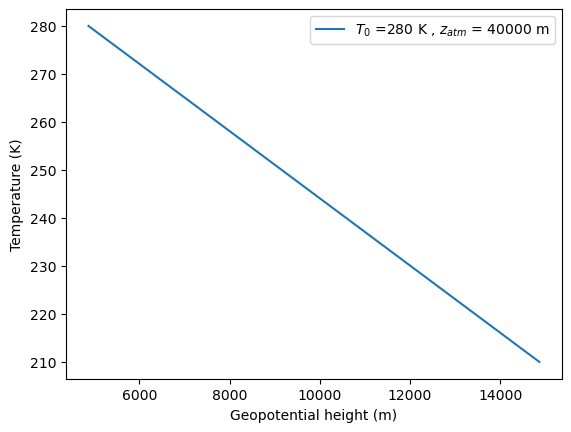

In [12]:
# Temperature of the atmosphere as a function of geopotential height
def atm_temp(z):
    return T_ground * (1 - (z-h)/z_atm)

z = np.linspace(h, h+1e4, 50)
plt.plot(z, atm_temp(z), label=r'$T_0$ =' + f'{T_ground} K , ' + r'$z_{atm}$ = ' + f'{z_atm} m')
plt.xlabel('Geopotential height (m)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

# Gaussian beam

We now use cylindrical coordinates defined by the detector.

$el$ is the elevation of the lign of sight of the detector.

$z$ is the distance to the detector along this lign of sight.

$r$ is the orthogonal distance to z.

$\theta$ is the angle of r, the reference is of no importance.

In [13]:
def gaussian_beam_width(z, freq):
    wavelength = scipy.constants.c / freq
    gaussian_beam_waist = wavelength / (np.pi * beam_FWHM) * np.sqrt(2 * np.log(2))
    return gaussian_beam_waist * np.sqrt(1 + (wavelength * z / (np.pi * gaussian_beam_waist**2))**2)

def gaussian_beam(z, r, freq):
    wavelength = scipy.constants.c / freq
    wz = gaussian_beam_width(z, freq)
    return 2/np.pi * (wavelength * z / wz)**2 * np.exp(- 2 * r**2 / wz**2)

def gaussian_beam_normalized(z, r, freq):
    '''
    The integral on any surface of constant z is 1
    '''
    wavelength = scipy.constants.c / freq
    wz = gaussian_beam_width(z, freq)
    return 2 / (np.pi * wz**2) * np.exp(- 2 * r**2 / wz**2)

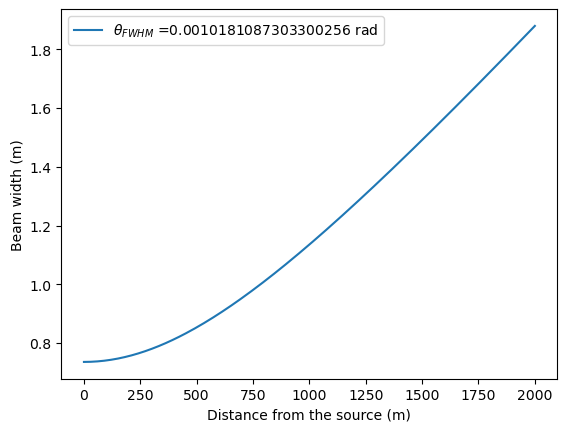

In [14]:
z = np.linspace(0, 2000, 200)
plt.plot(z, gaussian_beam_width(z, 150e9), 
         label=r'$\theta_{FWHM}$ =' + f'{beam_FWHM} rad')
plt.xlabel('Distance from the source (m)')
plt.ylabel('Beam width (m)')
plt.legend()
plt.show()

In [15]:
# Get the geopotential height from the cylindrical coordinates
def cylindrical_to_height(z, r, theta, el):
    return h + z * np.sin(el) - r * np.cos(theta) * np.cos(el)

We can now compute the integral over the atmosphere leading to a
temperature of the detector


In [16]:
def integrand_without_fluctuation_gaussian(theta, r, z, el, freq):
    height = cylindrical_to_height(z, r, theta, el)
    return water_vapor_density(height) * atm_temp(height) * gaussian_beam_normalized(z, r, freq)

def atm_contribution_without_fluctuation_gaussian(h_min, h_max, el, freq):
    ''' 
    h_min and h_max the geopotential heights borns of integration

    Integration on the section of the beam from 0 to w(z)
    '''
    z_min = (h_min - h) / np.sin(el)
    z_max = (h_max - h) / np.sin(el)
    return molecular_absorption_coeff * scipy.integrate.tplquad(integrand_without_fluctuation_gaussian, 
                                                                z_min, z_max, 0, lambda z : gaussian_beam_width(z, freq), 
                                                                0, 2*np.pi, args=[el, freq])[0]

In [17]:
N_heights = 10
height_list = np.logspace(np.log10(h), np.log10(h+5000), N_heights)

# We do the calculation by step
atm_contribution_90, atm_contribution_50, atm_contribution_30 = [0], [0], [0]
for i in range(N_heights-1):
    atm_contribution_90.append(atm_contribution_without_fluctuation_gaussian(height_list[i], height_list[i+1], np.radians(90), 150e9))
    atm_contribution_50.append(atm_contribution_without_fluctuation_gaussian(height_list[i], height_list[i+1], np.radians(50), 150e9))
    atm_contribution_30.append(atm_contribution_without_fluctuation_gaussian(height_list[i], height_list[i+1], np.radians(30), 150e9))

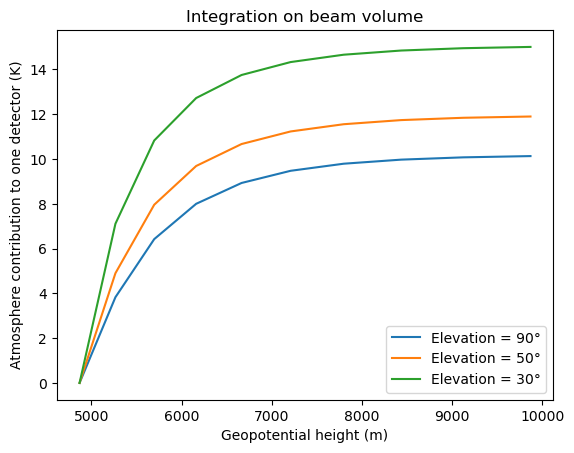

In [18]:
# And then add the steps together
for i in range(N_heights-1):
    atm_contribution_90[i+1] += atm_contribution_90[i]
    atm_contribution_50[i+1] += atm_contribution_50[i]
    atm_contribution_30[i+1] += atm_contribution_30[i]

plt.figure()
plt.plot(height_list, atm_contribution_90, label='Elevation = 90°')
plt.plot(height_list, atm_contribution_50, label='Elevation = 50°')
plt.plot(height_list, atm_contribution_30, label='Elevation = 30°')

plt.xlabel('Geopotential height (m)')
plt.ylabel('Atmosphere contribution to one detector (K)')
plt.title('Integration on beam volume')
plt.legend()
plt.show()

We can see that the atmosphere is contributing to the temperature of the
detector only up to 3 or 4 kms.

# Correlations

First, lets define some useful functions

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


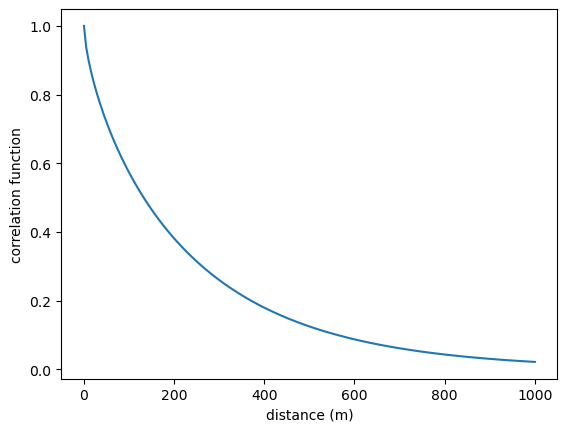

In [19]:
def gaussian_beam_normalized_detector(r_i, x, y, z, freq):
    '''
    The integral on any surface of constant z is 1

    r_i is the normalized vector of the direction of detector i. For the central detector it is (0,0,1)
    x, y, z coordinates in the sky
    '''
    wavelength = scipy.constants.c / freq
    scalar = np.dot(r_i, (x,y,z))
    wz = gaussian_beam_width(scalar, freq)
    return 2 / (np.pi * wz**2) * np.exp(- 2 * (x**2 + y**2 + z**2 - scalar**2) / wz**2)


def correlation_function(r, r0=300):
    '''
    Correlation function of water vapor as a function of distance r (Kolmogorov model)
    '''
    return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))

distances = np.linspace(0, 1000, 200)

plt.plot(distances, correlation_function(distances))
plt.xlabel('distance (m)')
plt.ylabel('correlation function')
plt.show()

In [20]:
# Scales a sample 
def scaling_function(arr, z_min_i, z_max_i, z_min_j, z_max_j, freq, r0):
    zi = arr[2]*r0-r0/2 + arr[5]*(z_max_i-z_min_i)+z_min_i
    zj = -(arr[2]*r0-r0/2) + arr[5]*(z_max_j-z_min_j)+z_min_j
    wz_i = gaussian_beam_width(zi, freq)
    wz_j = gaussian_beam_width(zj, freq)
    xy_min_i, xy_max_i = -wz_i, wz_i
    xy_min_j, xy_max_j = -wz_j, wz_j
    amplitude = np.array([xy_max_i-xy_min_i, xy_max_i-xy_min_i, np.sqrt(2)*r0, 
                          xy_max_j-xy_min_j, xy_max_j-xy_min_j, (z_max_i+z_max_j-z_min_i-z_min_j)/np.sqrt(2)])
    offset = np.array([xy_min_i, xy_min_i, -r0/np.sqrt(2), xy_min_j, xy_min_j, (z_min_i+z_min_j)/np.sqrt(2)])
    return arr * amplitude + offset
    
def is_in_the_beams(arr, z_min_i, z_max_i, z_min_j, z_max_j, freq):
    '''
    Check that a 6D point is in both beams
    '''
    wz_i = gaussian_beam_width(arr[2], freq)
    wz_j = gaussian_beam_width(arr[5], freq)
    if arr[2]>=z_min_i and arr[5]>=z_min_j and arr[2]<=z_max_i and arr[5]<=z_max_j and arr[0]**2+arr[1]**2 <= wz_i**2 and arr[3]**2+arr[4]**2 <= wz_j**2:
        return True
    return False

For the detectors i and j, we want to rotate the beams in direction r_i
and r_j.

Lets consider detector i. We make a rotation such that vector $(0,0,1)$
becomes $(r_x, r_y, r_z)$. The angle of rotation is $arccos(r_z)$ and
the axis of rotation is
$(0, \frac{-r_y}{\sqrt{r_x^2+r_y^2}}, \frac{r_x}{\sqrt{r_x^2+r_y^2}})$.
We can then compute the rotation matrix.

In [21]:
# Rotation matrix in six dimensions (two independant 3D rotations, one for each beam)
def rotation_matrix(r_i, r_j):
    rxi, ryi, rzi = r_i
    rxj, ryj, rzj = r_j
    sin2_i = rxi**2 + ryi**2 # carré du sinus de l'angle de rotation
    sin2_j = rxj**2 + ryj**2

    if rxi==0 and ryi==0:
        L1 = [1,0,0,0,0,0]
        L2 = [0,1,0,0,0,0]
        L3 = [0,0,1,0,0,0]
    else:
        L1 = [ryi**2*(1-rzi)/sin2_i+rzi, -rxi*ryi*(1-rzi)/sin2_i, -rxi, 0, 0, 0]
        L2 = [-rxi*ryi*(1-rzi)/sin2_i, rxi**2*(1-rzi)/sin2_i+rzi, -ryi, 0, 0, 0]
        L3 = [rxi, ryi, rzi, 0, 0, 0]
    if rxj==0 and ryj==0:
        L4 = [0,0,0,1,0,0]
        L5 = [0,0,0,0,1,0]
        L6 = [0,0,0,0,0,1]
    else:
        L4 = [0, 0, 0, ryj**2*(1-rzj)/sin2_j+rzj, -rxj*ryj*(1-rzj)/sin2_j, -rxj]
        L5 = [0, 0, 0, -rxj*ryj*(1-rzj)/sin2_j, rxj**2*(1-rzj)/sin2_j+rzj, -ryj]
        L6 = [0, 0, 0, rxj, ryj, rzj]
    Rxy = np.array([L1, L2, L3, L4, L5, L6])
    return Rxy

Then we simulate a sample of points following a Sobol’ sequence in 6
dimensions in order to perform a Quais-Monte Carlo integral.

We define the intergand.

Finaly we compute the integral.

In [22]:
# Function to generate integration points within variable-dependent bounds
def integration_points(h_min, h_max, r_i, r_j, el, freq, n, r0=300):
    '''
    Returns a sample of points that are in the two beams (so in 6 dimensions). 
    This is done using a Sobol' sequence to have a uniform distribution in the 6D space.
    The number of points generated is roughly 2**n /2
    '''

    # Generates the points in 6D space
    sampler = qmc.Sobol(d=6, scramble=False)
    points = sampler.random_base2(m=n)

    # Elevation of each detector
    sin_el_i = r_i[1]*np.cos(el) + r_i[2]*np.sin(el)
    sin_el_j = r_j[1]*np.cos(el) + r_j[2]*np.sin(el)
    
    z_min_i = (h_min - h) / sin_el_i
    z_max_i = (h_max - h) / sin_el_i
    z_min_j = (h_min - h) / sin_el_j
    z_max_j = (h_max - h) / sin_el_j

    # We don't take into account points such that |zi-zj|>r0
    z_min_i = max((z_min_i, z_min_j-r0))
    z_min_j = max((z_min_j, z_min_i-r0))
    z_max_i = min((z_max_i, z_max_j+r0))
    z_max_j = min((z_max_j, z_max_i+r0))

    # Scales the points aproximatly in the beams.
    # We want the distance between zi and zj to be less than r0, so we first create a rectangle of size (sqrt(2)*(z_max-z_min), sqrt(2)*r0)
    # in the (zi, zj) plane and we will then perform a 45° rotation in this plane to have the true distances zi and zj.
    # For (xi, yi), we scale the points in a square of length 2*beam_width(zi). Same for (xj, yj).
    scaled_points = np.apply_along_axis(scaling_function, 1, points, z_min_i=z_min_i, z_max_i=z_max_i, 
                                        z_min_j=z_min_j, z_max_j=z_max_j, freq=freq, r0=r0)

    # We perform the rotation of 45° in the (zi, zj)
    Rz = np.zeros((6,6))
    Rz[0,0], Rz[1,1], Rz[3,3], Rz[4,4] = 1, 1, 1, 1
    Rz[2,2], Rz[2,5], Rz[5,2], Rz[5,5] = 1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2), 1/np.sqrt(2)
    scaled_points_tilt = scaled_points @ Rz

                             
    # Mask the points not in the beams
    mask = np.apply_along_axis(is_in_the_beams, 1, scaled_points_tilt, z_min_i=z_min_i, z_max_i=z_max_i, 
                                        z_min_j=z_min_j, z_max_j=z_max_j, freq=freq)
    masked_points = scaled_points_tilt[mask]

    # Perform a rotation for each beam to bring it to the direction it it pointing at (r_i and r_j)
    masked_points_tilt = masked_points @ rotation_matrix(r_i, r_j)

    return scaled_points, masked_points, masked_points_tilt

In [23]:
def integrand_correlations_gaussian(arr, r_i, r_j, el, freq, r0=300):
    '''
    Integrand for the correlation function.
    arr is the 6 dimensions coordinates of a pair of points.
    r_i is the direction of detector i, and r_j of detector j
    el is the elevation
    freq the frequence
    '''
    xi, yi, zi, xj, yj, zj = arr

    # Elevation of each detector
    sin_el_i = r_i[1]*np.cos(el) + r_i[2]*np.sin(el)
    sin_el_j = r_j[1]*np.cos(el) + r_j[2]*np.sin(el)

    # Geopotential height
    height_i = h + zi*sin_el_i + yi*np.sqrt(1-sin_el_i**2)
    height_j = h + zj*sin_el_j + yj*np.sqrt(1-sin_el_j**2)

    # Distance between the two points in the sky
    r_ij = np.sqrt((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2) 
    
    #correlation_function(r_ij) * 
    return correlation_function(r_ij, r0=r0) * water_vapor_density(height_i) * water_vapor_density(height_j) * atm_temp(height_i) * atm_temp(height_j) * gaussian_beam_normalized_detector(r_i, xi, yi, zi, freq) * gaussian_beam_normalized_detector(r_j, xj, yj, zj, freq)

In [24]:
def atm_correlations_gaussian(h_min, h_max, r_i, r_j, el, freq, n, r0=300):
    points = integration_points(h_min, h_max, r_i, r_j, el, freq, n, r0=r0)[2]

    # Elevation of each detector
    sin_el_i = r_i[1]*np.cos(el) + r_i[2]*np.sin(el)
    sin_el_j = r_j[1]*np.cos(el) + r_j[2]*np.sin(el)
    
    z_min_i = (h_min - h) / sin_el_i
    z_max_i = (h_max - h) / sin_el_i
    z_min_j = (h_min - h) / sin_el_j
    z_max_j = (h_max - h) / sin_el_j

    # We don't take into account points such that |zi-zj|>r0
    z_min_i = max((z_min_i, z_min_j-r0))
    z_min_j = max((z_min_j, z_min_i-r0))
    z_max_i = min((z_max_i, z_max_j+r0))
    z_max_j = min((z_max_j, z_max_i+r0))

    # To compute the integral we need to weight by the surface at each height zi or zj 
    # to take into account that the density of points changes with height
    int = 0
    for arr in points:
        wz_i = gaussian_beam_width(arr[2], freq)
        wz_j = gaussian_beam_width(arr[5], freq)
        int += integrand_correlations_gaussian(arr, r_i, r_j, el, freq, r0=r0) * wz_i**2 * wz_j**2 * np.pi**2

    # Surface in the (zi,zj) plane
    Sz = (z_max_i-z_min_i)*(z_max_j-z_min_j) - (z_max_i-z_min_j-r0)**2 /2 - (z_max_j-z_min_i-r0)**2 /2
    
    return np.shape(points)[0], molecular_absorption_coeff**2 * int / np.shape(points)[0] * Sz

## Measure the convergence

We first want to compute the convergence of the integral as a function
of the number of simulated points.

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


[5, 10, 24, 39, 82, 160, 315, 613, 1208, 2404, 4803, 9606]
[3.7951868910719617, 3.0291961253149235, 1.9466390501998088, 1.77843353230957, 1.8981805265016773, 1.7450522688196841, 1.7371164277217253, 1.7346075161577863, 1.7551695331193513, 1.7553834614410795, 1.7708604422201022, 1.7660800510890116]


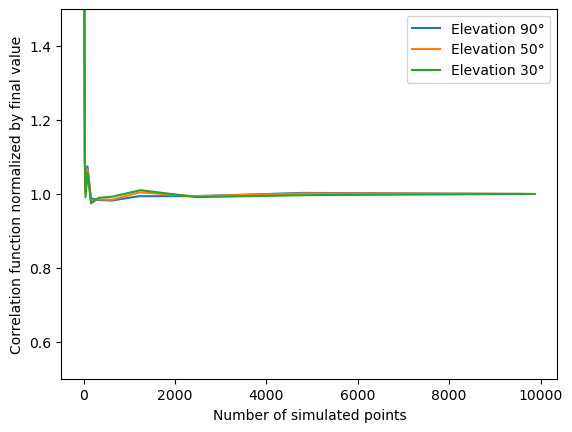

In [25]:
nb_90, nb_50, nb_30 = [], [], [] # real number of points in the beams
corr_90, corr_50, corr_30 = [], [], [] # correlations
for k in range(3, 15):
    n, c = atm_correlations_gaussian(h, h+3000, (0,0,1), (0,0,1), np.radians(90), 150e9, k)
    nb_90.append(n); corr_90.append(c)
    n, c = atm_correlations_gaussian(h, h+3000, (0,0,1), (0,0,1), np.radians(50), 150e9, k)
    nb_50.append(n); corr_50.append(c)
    n, c = atm_correlations_gaussian(h, h+3000, (0,0,1), (0,0,1), np.radians(30), 150e9, k)
    nb_30.append(n); corr_30.append(c)
print(nb_90)
print(corr_90)

plt.plot(nb_90, corr_90/corr_90[-1], label='Elevation 90°')
plt.plot(nb_50, corr_50/corr_50[-1], label='Elevation 50°')
plt.plot(nb_30, corr_30/corr_30[-1], label='Elevation 30°')
plt.ylim(bottom=0.5, top=1.5)
plt.xlabel('Number of simulated points')
plt.ylabel('Correlation function normalized by final value')
plt.legend()
plt.show()

\~160 points leads to a few percents change, this corresponds to n=8.

Only a few tens of ms are needed to do this computation:

In [26]:
# %timeit atm_correlations_gaussian(h, h+3000, (0,0,1), (0,0,1), np.pi/2, 150e9, 8)

Lets plot the simulated points on the two beams

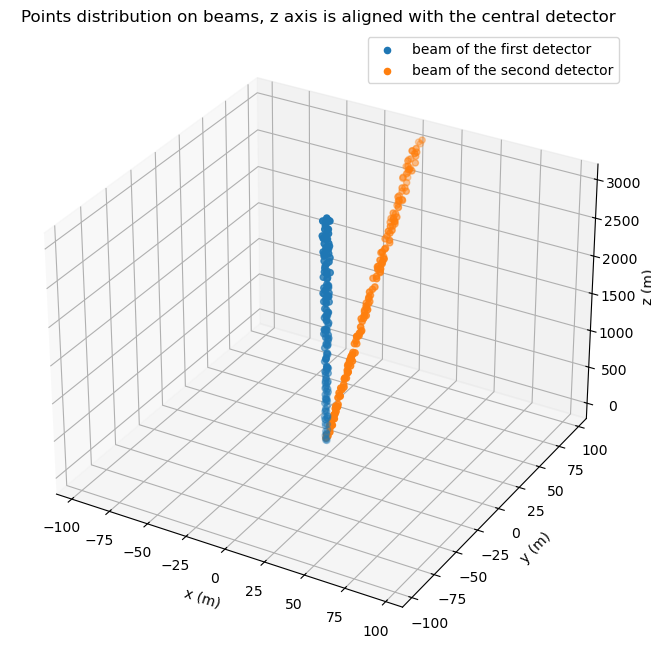

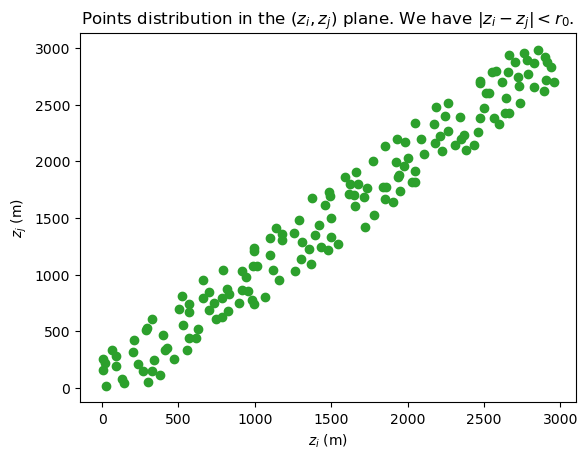

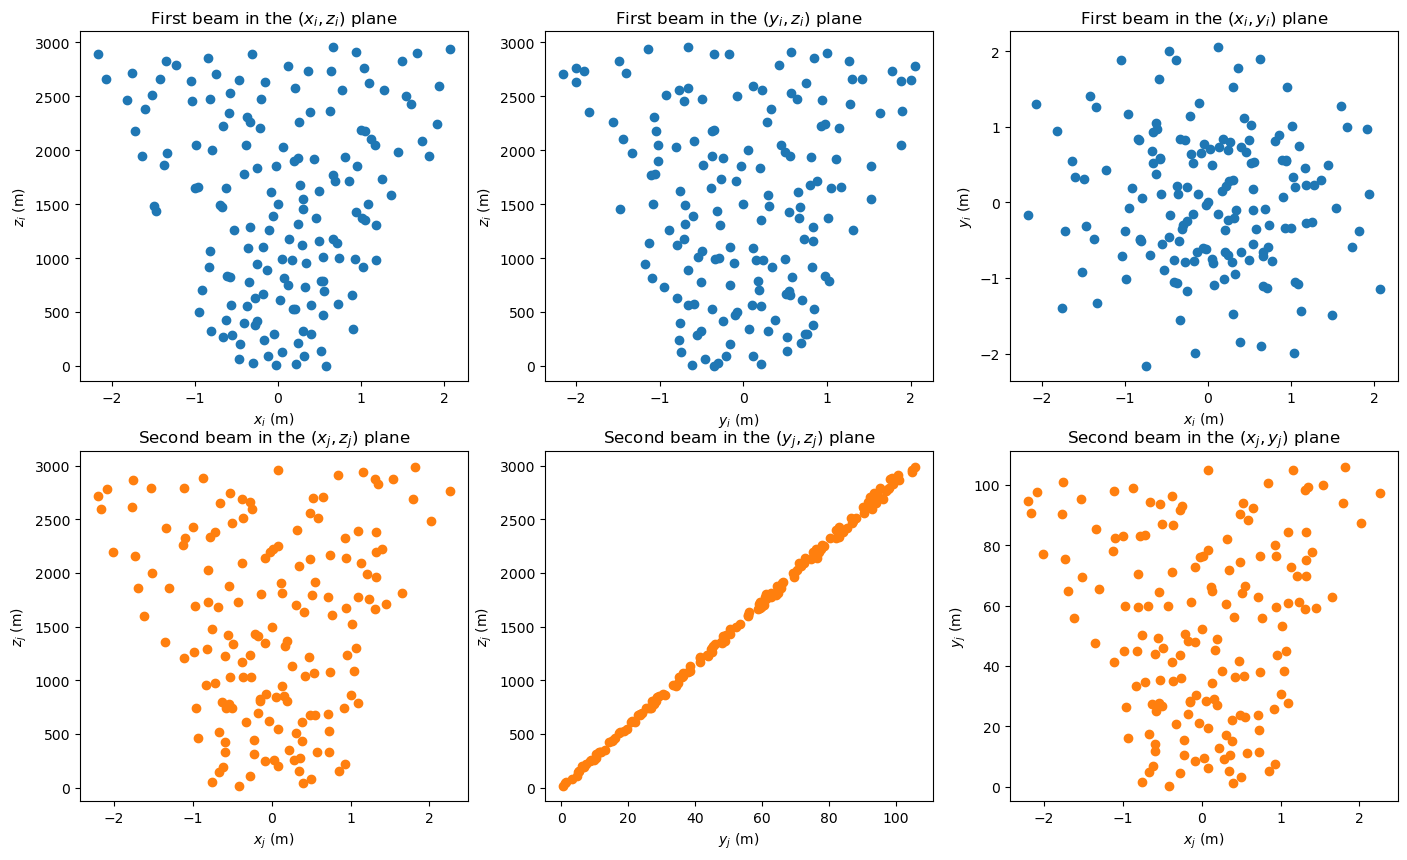

In [27]:
scaled_points, scaled_points_tilt, masked_points = integration_points(
    h, h+3000, (0,0,1), (0,np.sin(np.radians(2)),np.cos(np.radians(2))), np.radians(90), 120e9, 8)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(masked_points[:, 0], masked_points[:, 1], masked_points[:, 2], label='beam of the first detector', c='tab:blue')
scatter = ax.scatter(masked_points[:, 3], masked_points[:, 4], masked_points[:, 5], label='beam of the second detector', c='tab:orange')

# Set labels
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.set_title('Points distribution on beams, z axis is aligned with the central detector')
limit = np.max((np.max(np.abs(masked_points[:, 0])), np.max(np.abs(masked_points[:, 1])), 
                np.max(np.abs(masked_points[:, 3])), np.max(np.abs(masked_points[:, 4]))))
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
plt.legend()
plt.show()

plt.scatter(scaled_points_tilt[:, 2], scaled_points_tilt[:, 5], c='tab:green')
plt.xlabel(r'$z_i$'+' (m)')
plt.ylabel(r'$z_j$'+' (m)')
plt.title('Points distribution in the '+r'$(z_i, z_j)$'+' plane. We have '+r'$\vert z_i-z_j\vert < r_0.$')
plt.show()

plt.figure(figsize = (17,10))

plt.subplot(2,3,1)
plt.scatter(masked_points[:, 0], masked_points[:, 2], c='tab:blue')
plt.xlabel(r'$x_i$'+' (m)')
plt.ylabel(r'$z_i$'+' (m)')
plt.title('First beam in the '+r'$(x_i, z_i)$'+' plane')

plt.subplot(2,3,2)
plt.scatter(masked_points[:, 1], masked_points[:, 2], c='tab:blue')
plt.xlabel(r'$y_i$'+' (m)')
plt.ylabel(r'$z_i$'+' (m)')
plt.title('First beam in the '+r'$(y_i, z_i)$'+' plane')

plt.subplot(2,3,3)
plt.scatter(masked_points[:, 0], masked_points[:, 1], c='tab:blue')
plt.xlabel(r'$x_i$'+' (m)')
plt.ylabel(r'$y_i$'+' (m)')
plt.title('First beam in the '+r'$(x_i, y_i)$'+' plane')

plt.subplot(2,3,4)
plt.scatter(masked_points[:, 3], masked_points[:, 5], c='tab:orange')
plt.xlabel(r'$x_j$'+' (m)')
plt.ylabel(r'$z_j$'+' (m)')
plt.title('Second beam in the '+r'$(x_j, z_j)$'+' plane')

plt.subplot(2,3,5)
plt.scatter(masked_points[:, 4], masked_points[:, 5], c='tab:orange')
plt.xlabel(r'$y_j$'+' (m)')
plt.ylabel(r'$z_j$'+' (m)')
plt.title('Second beam in the '+r'$(y_j, z_j)$'+' plane')

plt.subplot(2,3,6)
plt.scatter(masked_points[:, 3], masked_points[:, 4], c='tab:orange')
plt.xlabel(r'$x_j$'+' (m)')
plt.ylabel(r'$y_j$'+' (m)')
plt.title('Second beam in the '+r'$(x_j, y_j)$'+' plane')
plt.show()

We can compute the height of the atmosphere contributing to the
correlation.

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


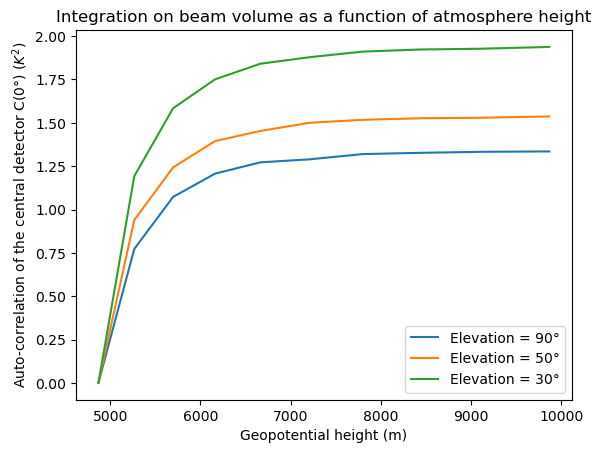

In [28]:
height_list = np.logspace(np.log10(h), np.log10(h+5000), 10)

correlations_90=[0]
correlations_50=[0]
correlations_30=[0]
for height in height_list[1::]:
    correlations_90.append(atm_correlations_gaussian(h, height, (0,0,1), (0,0,1), np.radians(90), 150e9, 8)[1])
    correlations_50.append(atm_correlations_gaussian(h, height, (0,0,1), (0,0,1), np.radians(50), 150e9, 8)[1])
    correlations_30.append(atm_correlations_gaussian(h, height, (0,0,1), (0,0,1), np.radians(30), 150e9, 10)[1])


plt.figure()
plt.plot(height_list, np.sqrt(correlations_90), label='Elevation = 90°')
plt.plot(height_list, np.sqrt(correlations_50), label='Elevation = 50°')
plt.plot(height_list, np.sqrt(correlations_30), label='Elevation = 30°')

plt.xlabel('Geopotential height (m)')
plt.ylabel('Auto-correlation of the central detector C(0°) '+r'$(K^2)$')
plt.title('Integration on beam volume as a function of atmosphere height')
plt.legend()
plt.show()

Only the first 3kms play a major role in the value of the correlation

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


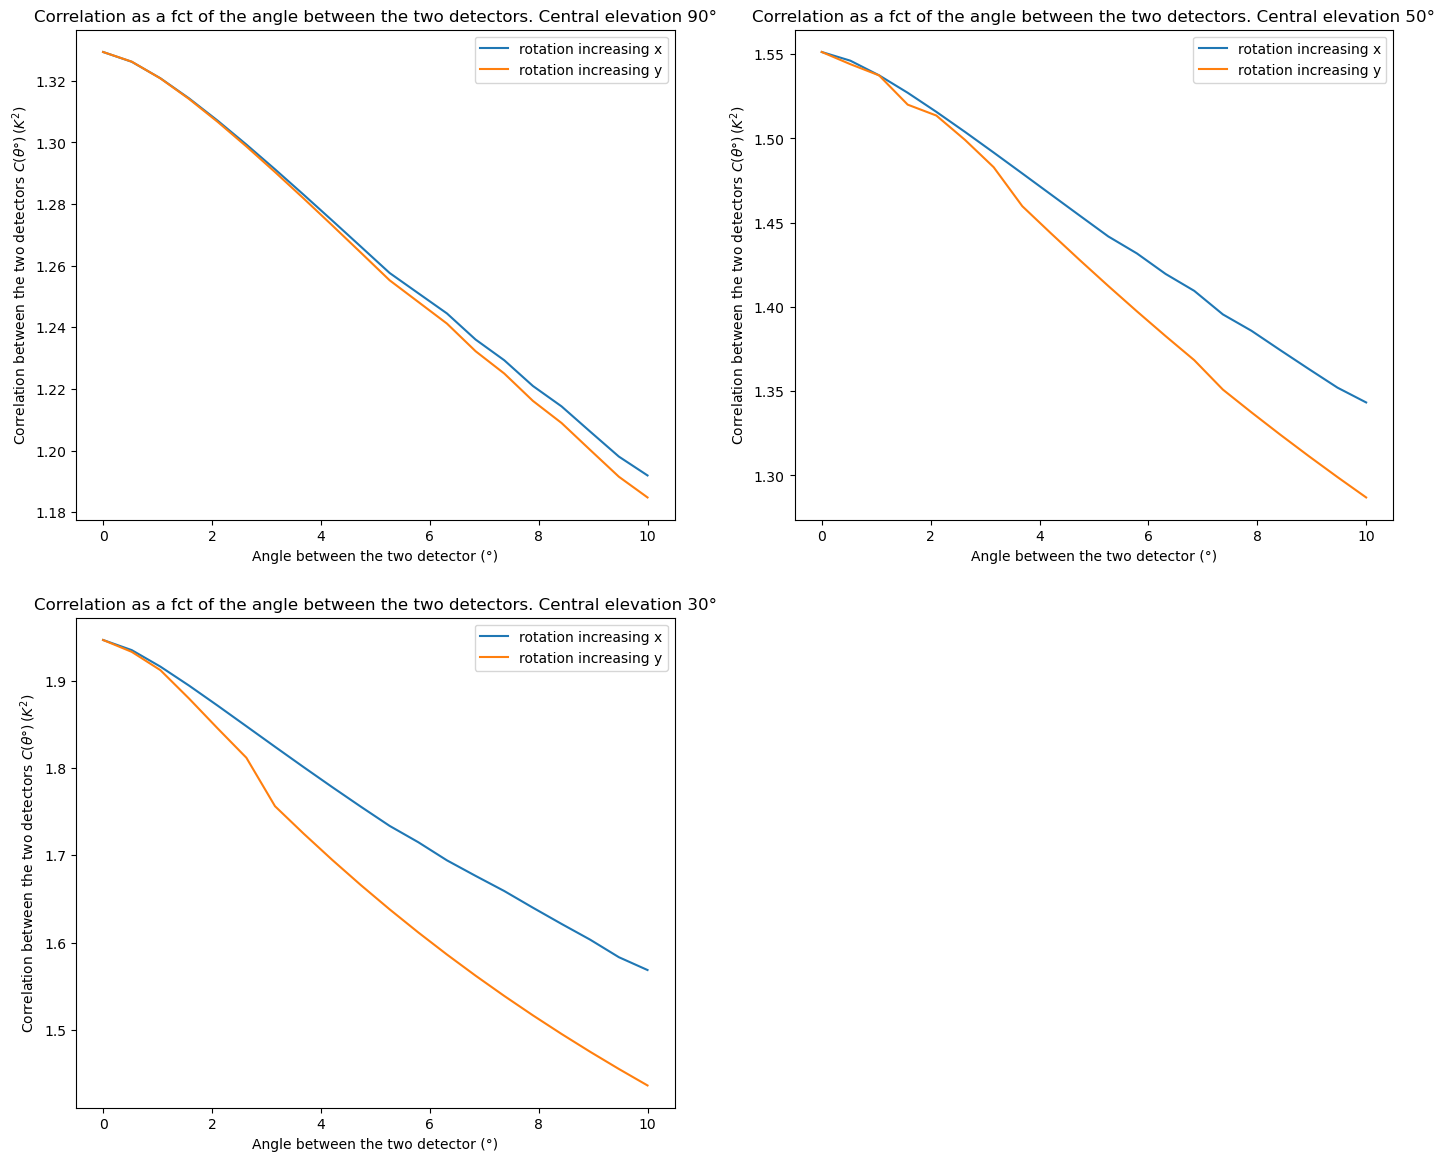

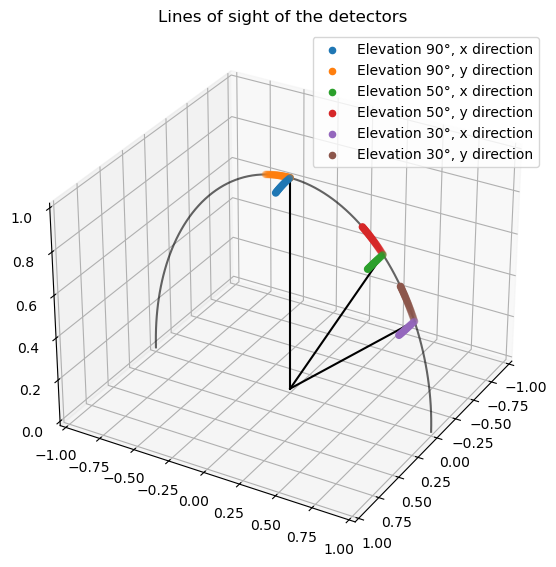

In [29]:
angle_list = np.linspace(0, 10, 20)

correlations_angle_90_x = []
correlations_angle_90_y = []
correlations_angle_50_x = []
correlations_angle_50_y = []
correlations_angle_30_x = []
correlations_angle_30_y = []

for angle in angle_list:
    correlations_angle_90_x.append(atm_correlations_gaussian(
        h, h+5000, (0,0,1), (np.sin(np.radians(angle)),0,np.cos(np.radians(angle))), np.radians(90), 150e9, 9)[1])
    correlations_angle_90_y.append(atm_correlations_gaussian(
        h, h+5000, (0,0,1), (0,np.sin(np.radians(angle)),np.cos(np.radians(angle))), np.radians(90), 150e9, 9)[1])
    correlations_angle_50_x.append(atm_correlations_gaussian(
        h, h+5000, (0,0,1), (np.sin(np.radians(angle)),0,np.cos(np.radians(angle))), np.radians(50), 150e9, 9)[1])
    correlations_angle_50_y.append(atm_correlations_gaussian(
        h, h+5000, (0,0,1), (0,np.sin(np.radians(angle)),np.cos(np.radians(angle))), np.radians(50), 150e9, 9)[1])
    correlations_angle_30_x.append(atm_correlations_gaussian(
        h, h+5000, (0,0,1), (np.sin(np.radians(angle)),0,np.cos(np.radians(angle))), np.radians(30), 150e9, 9)[1])
    correlations_angle_30_y.append(atm_correlations_gaussian(
        h, h+5000, (0,0,1), (0,np.sin(np.radians(angle)),np.cos(np.radians(angle))), np.radians(30), 150e9, 9)[1])
    
plt.figure(figsize = (17,14))

plt.subplot(2,2,1)
plt.plot(angle_list, np.sqrt(correlations_angle_90_x), label='rotation increasing x')
plt.plot(angle_list, np.sqrt(correlations_angle_90_y), label='rotation increasing y')

plt.xlabel('Angle between the two detector (°)')
plt.ylabel('Correlation between the two detectors '+r'$C(\theta °)\, ({K}^2)$')
plt.title('Correlation as a fct of the angle between the two detectors. Central elevation 90°')
plt.legend()

plt.subplot(2,2,2)
plt.plot(angle_list, np.sqrt(correlations_angle_50_x), label='rotation increasing x')
plt.plot(angle_list, np.sqrt(correlations_angle_50_y), label='rotation increasing y')

plt.xlabel('Angle between the two detector (°)')
plt.ylabel('Correlation between the two detectors '+r'$C(\theta °)\, ({K}^2)$')
plt.title('Correlation as a fct of the angle between the two detectors. Central elevation 50°')
plt.legend()

plt.subplot(2,2,3)
plt.plot(angle_list, np.sqrt(correlations_angle_30_x), label='rotation increasing x')
plt.plot(angle_list, np.sqrt(correlations_angle_30_y), label='rotation increasing y')

plt.xlabel('Angle between the two detector (°)')
plt.ylabel('Correlation between the two detectors '+ r'$C(\theta °)\, ({K}^2)$')
plt.title('Correlation as a fct of the angle between the two detectors. Central elevation 30°')
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 4, projection='3d')

for elevation in [90, 50, 30]:
    el = np.radians(elevation)
    beam_x = np.transpose(np.array([np.sin(np.radians(angle_list)), np.cos(el)*np.cos(np.radians(angle_list)), np.sin(el)*np.cos(np.radians(angle_list))]))
    beam_y = np.transpose(np.array([np.zeros(np.shape(angle_list)[0]), np.cos(el+np.radians(angle_list)), np.sin(el+np.radians(angle_list))]))
    ax.scatter(beam_x[:,0], beam_x[:,1], beam_x[:,2], label='Elevation '+str(elevation)+'°, x direction')
    ax.scatter(beam_y[:,0], beam_y[:,1], beam_y[:,2], label='Elevation '+str(elevation)+'°, y direction')
    ax.plot([0,0], [0,np.cos(el)], [0, np.sin(el)], c='black')
ax.plot(np.zeros(100), np.cos(np.linspace(0, np.pi, 100)), np.sin(np.linspace(0, np.pi, 100)), c='black', alpha=0.6)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(0,1)
ax.set_title('Lines of sight of the detectors')
ax.view_init(elev=30, azim=30)
plt.legend()
plt.show()

The z axis is the lign of sight of the central detector. y is the
orthogonal direction going towards the zenith. x is the orthogonal
direction to y and z.

At elevation 90°, we are expecting the same result in directions x and y
as the problem has a symmetry of rotation.

But at elevation 50°, the second beam won’t have the same elevation if
it rotates along the x or the y axis. This will change the behavior of
the mean density of water vapor function, and of the temperature
function. So the correlation functions won’t be the same.

At elevation 30°, the effect is even greater.

This is qualitatively what we observe in those simulations.

# Wind

Wind will influence the turbulence part of the integral. Wind is
supposed to be horizontal and idenpendant of the altitude. We will
denote $W$ it’s norm in $m~s^{-1}$, and $\phi_W$ it’s azimutal angle. So
we have: $$\vec{W}=\cos{\phi_W}\vec{N}+\sin{\phi_W}\vec{E},$$ with
$\vec{N}$ the unitary vector going north and $vec{E}$ the unitary vector
going east.

If we consider two points in the sky $\vec{r}(t)$ and $\vec{r}'(t')$,
their apparent distance due to the wind will be:
$$\vert \vec{r}'(t')-\vec{r}(t) \vert_{\text{wind}} = \vert \vec{r}'(t')-\vec{r}(t) - \vec{W}(t'-t) \vert.$$
This new expression will be used to compute the turbulent correlation in
Kolmogorv’s model. This is the only change to include wind.

Note that before, correlations were invariant in time (as long as we
don’t do a scan) and invariant in the azimuthal direction of the central
detector. Wind breaks those two symmetries.

In [30]:
def xyz_to_NWZ(x, y, z, az, el):
    '''
    Transform the coordinates in the frame of the detector to the coordinates system (North, West, Zenith)
    '''
    N = x*np.sin(az) - y*np.sin(el)*np.cos(az) + z*np.cos(el)*np.cos(az)
    W = x*np.cos(az) + y*np.sin(el)*np.sin(az) - z*np.cos(el)*np.sin(az)
    Z = y*np.cos(el) + z*np.sin(el)
    return N, W, Z

In [31]:
# Function to generate integration points within variable-dependent bounds
def integration_points_wind(h_min, h_max, r_i, el_ti, r_j, el_tj, freq, n, r0=300):
    '''
    Returns a sample of points that are in the two beams (so in 6 dimensions). 
    This is done using a Sobol' sequence to have a uniform distribution in the 6D space.
    The number of points generated is roughly 2**n /2
    '''

    # Generates the points in 6D space
    sampler = qmc.Sobol(d=6, scramble=False)
    points = sampler.random_base2(m=n)

    # Elevation of each detector
    sin_el_i = r_i[1]*np.cos(el_ti) + r_i[2]*np.sin(el_ti)
    sin_el_j = r_j[1]*np.cos(el_tj) + r_j[2]*np.sin(el_tj)
    
    z_min_i = (h_min - h) / sin_el_i
    z_max_i = (h_max - h) / sin_el_i
    z_min_j = (h_min - h) / sin_el_j
    z_max_j = (h_max - h) / sin_el_j

    # We don't take into account points such that |zi-zj|>r0
    z_min_i = max((z_min_i, z_min_j-r0))
    z_min_j = max((z_min_j, z_min_i-r0))
    z_max_i = min((z_max_i, z_max_j+r0))
    z_max_j = min((z_max_j, z_max_i+r0))

    # Scales the points aproximatly in the beams.
    # We want the distance between zi and zj to be less than r0, so we first create a rectangle of size (sqrt(2)*(z_max-z_min), sqrt(2)*r0)
    # in the (zi, zj) plane and we will then perform a 45° rotation in this plane to have the true distances zi and zj.
    # For (xi, yi), we scale the points in a square of length 2*beam_width(zi). Same for (xj, yj).
    scaled_points = np.apply_along_axis(scaling_function, 1, points, z_min_i=z_min_i, z_max_i=z_max_i, 
                                        z_min_j=z_min_j, z_max_j=z_max_j, freq=freq, r0=r0)

    # We perform the rotation of 45° in the (zi, zj)
    Rz = np.zeros((6,6))
    Rz[0,0], Rz[1,1], Rz[3,3], Rz[4,4] = 1, 1, 1, 1
    Rz[2,2], Rz[2,5], Rz[5,2], Rz[5,5] = 1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2), 1/np.sqrt(2)
    scaled_points_tilt = scaled_points @ Rz

                             
    # Mask the points not in the beams
    mask = np.apply_along_axis(is_in_the_beams, 1, scaled_points_tilt, z_min_i=z_min_i, z_max_i=z_max_i, 
                                        z_min_j=z_min_j, z_max_j=z_max_j, freq=freq)
    masked_points = scaled_points_tilt[mask]

    # Perform a rotation for each beam to bring it to the direction it it pointing at (r_i and r_j)
    masked_points_tilt = masked_points @ rotation_matrix(r_i, r_j)

    return scaled_points, masked_points, masked_points_tilt

In [32]:
def integrand_correlations_gaussian_wind(arr, r_i, ti, az_ti, el_ti, r_j, tj, az_tj, el_tj, W, phi_W, freq, r0=300):
    '''
    Integrand for the correlation function.
    arr is the 6 dimensions coordinates of a pair of points.
    r_i is the direction of detector i, and r_j of detector j
    ti and tj are the moment of observation for detector i and j
    az_ti and el_tj is the azimuth and the elevation of the central detector at time ti
    W the norm of the speed of the wind
    phi_W the azimuth of the wind
    freq the frequence
    '''
    xi, yi, zi, xj, yj, zj = arr

    # Elevation of each detector
    sin_el_i = r_i[1]*np.cos(el_ti) + r_i[2]*np.sin(el_ti)
    sin_el_j = r_j[1]*np.cos(el_tj) + r_j[2]*np.sin(el_tj)

    # Geopotential height
    height_i = h + zi*sin_el_i + yi*np.sqrt(1-sin_el_i**2)
    height_j = h + zj*sin_el_j + yj*np.sqrt(1-sin_el_j**2)

    # Distance between the two points in the sky taking into account the wind
    Ni, Wi, Zi = xyz_to_NWZ(xi, yi, zi, az_ti, el_ti)
    Nj, Wj, Zj = xyz_to_NWZ(xj, yj, zj, az_tj, el_tj)
    N_wind, W_wind = np.cos(phi_W)*W*(tj-ti), -np.sin(phi_W)*W*(tj-ti) # Spatial shift due to the wind
    r_ij = np.sqrt((Nj-Ni-N_wind)**2 + (Wj-Wi-W_wind)**2 + (Nj-Ni)**2) 
    
    #correlation_function(r_ij) * 
    return correlation_function(r_ij, r0=r0) * water_vapor_density(height_i) * water_vapor_density(height_j) * atm_temp(height_i) * atm_temp(height_j) * gaussian_beam_normalized_detector(r_i, xi, yi, zi, freq) * gaussian_beam_normalized_detector(r_j, xj, yj, zj, freq)

In [33]:
def atm_correlations_gaussian_wind(h_min, h_max, r_i, ti, az_ti, el_ti, r_j, tj, az_tj, el_tj, W, phi_W, freq, n, r0=300):
    points = integration_points_wind(h_min, h_max, r_i, el_ti, r_j, el_tj, freq, n, r0=r0)[2]

    # Elevation of each detector
    sin_el_i = r_i[1]*np.cos(el_ti) + r_i[2]*np.sin(el_ti)
    sin_el_j = r_j[1]*np.cos(el_tj) + r_j[2]*np.sin(el_tj)
    
    z_min_i = (h_min - h) / sin_el_i
    z_max_i = (h_max - h) / sin_el_i
    z_min_j = (h_min - h) / sin_el_j
    z_max_j = (h_max - h) / sin_el_j

    # We don't take into account points such that |zi-zj|>r0
    z_min_i = max((z_min_i, z_min_j-r0))
    z_min_j = max((z_min_j, z_min_i-r0))
    z_max_i = min((z_max_i, z_max_j+r0))
    z_max_j = min((z_max_j, z_max_i+r0))

    # To compute the integral we need to weight by the surface at each height zi or zj 
    # to take into account that the density of points changes with height
    int = 0
    for arr in points:
        wz_i = gaussian_beam_width(arr[2], freq)
        wz_j = gaussian_beam_width(arr[5], freq)
        int += integrand_correlations_gaussian_wind(
            arr, r_i, ti, az_ti, el_ti, r_j, tj, az_tj, el_tj, W, phi_W, freq, r0=r0) * wz_i**2 * wz_j**2 * np.pi**2

    # Surface in the (zi,zj) plane
    Sz = (z_max_i-z_min_i)*(z_max_j-z_min_j) - (z_max_i-z_min_j-r0)**2 /2 - (z_max_j-z_min_i-r0)**2 /2
    
    return np.shape(points)[0], molecular_absorption_coeff**2 * int / np.shape(points)[0] * Sz

# Scanning

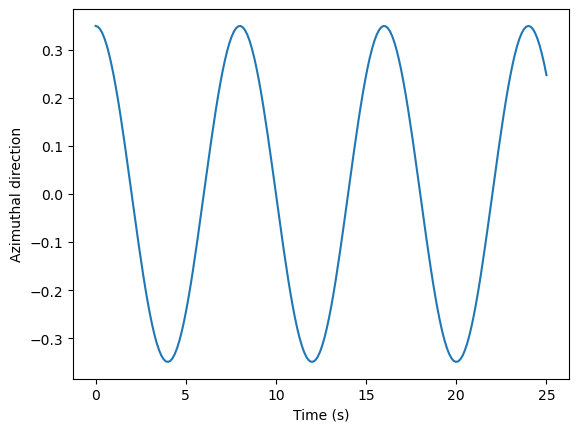

In [34]:
#Simulation parameters

W = 0                        # Speed of the wind (m s^-1)
phi_W = 0                    # Azimuth of the wind (rad)
delta_az = np.radians(40)     # Angular size of the scan in the azimuth direction (rad)
ss = np.radians(5)           # Scanning speed (rad s^-1)
f_scan = ss/(delta_az)      # Scan frequency (Hz)

time_list = np.linspace(0, 25, 200)
azimuth_list = delta_az / 2 * np.cos(2*np.pi * f_scan * time_list)

plt.plot(time_list, azimuth_list)
plt.xlabel('Time (s)')
plt.ylabel('Azimuthal direction')
plt.show()

# Correlations

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


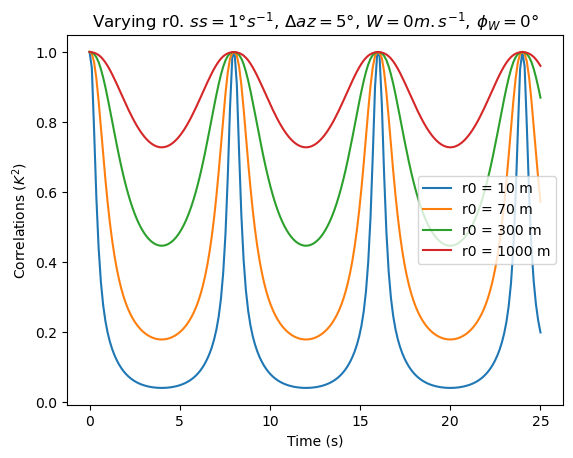

In [35]:
r0_list = [10, 70, 300, 1000]

for r0 in r0_list:
    corr = atm_correlations_gaussian_wind(h, h+3000, r_i=(0,0,1), ti=0, az_ti=azimuth_list[0], el_ti=np.radians(45), r_j=(0,0,1), 
                               tj=time_list, az_tj=azimuth_list, el_tj=np.radians(45), W=W, phi_W=phi_W, freq=150e9, n=8, r0=r0)[1]
    plt.plot(time_list, corr/corr[0], label='r0 = '+str(r0)+' m')

plt.xlabel('Time (s)')
plt.ylabel('Correlations '+r'$(K^2)$')
plt.title('Varying r0. '+r'$ss = 1°s^{-1},\, \Delta az = 5°,\, W = 0 m.s^{-1},\, \phi_W = 0°$')
plt.legend()
plt.show()

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


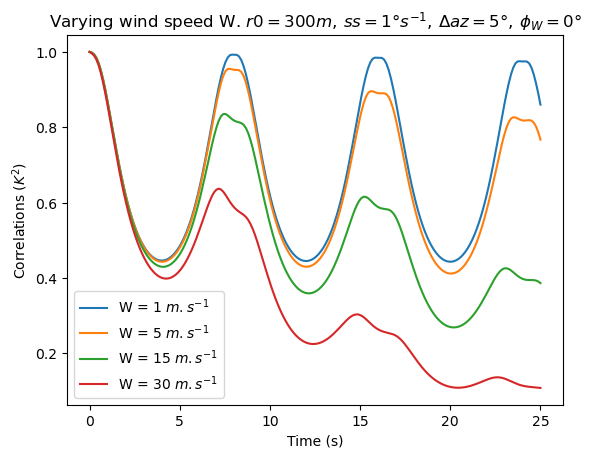

In [36]:
W_list = [1, 5, 15, 30]

for Wind in W_list:
    corr = atm_correlations_gaussian_wind(h, h+3000, r_i=(0,0,1), ti=0, az_ti=azimuth_list[0], el_ti=np.radians(45), r_j=(0,0,1), 
                               tj=time_list, az_tj=azimuth_list, el_tj=np.radians(45), W=Wind, phi_W=phi_W, freq=150e9, n=8, r0=300)[1]
    plt.plot(time_list, corr/corr[0], label='W = '+str(Wind)+r' $m.s^{-1}$')

plt.xlabel('Time (s)')
plt.ylabel('Correlations '+r'$(K^2)$')
plt.title('Varying wind speed W. '+r'$r0 = 300 m,\, ss = 1°s^{-1},\, \Delta az = 5°,\, \phi_W = 0°$')
plt.legend()
plt.show()

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


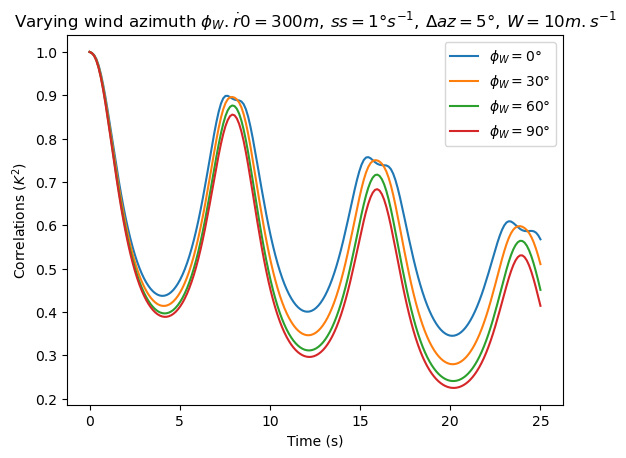

In [37]:
phi_W_list = [0, 30, 60, 90]

for phi_Wind in phi_W_list:
    corr = atm_correlations_gaussian_wind(h, h+3000, r_i=(0,0,1), ti=0, az_ti=azimuth_list[0], el_ti=np.radians(45), r_j=(0,0,1), 
                               tj=time_list, az_tj=azimuth_list, el_tj=np.radians(45), W=10, phi_W=np.radians(phi_Wind), freq=150e9, n=8, r0=300)[1]
    plt.plot(time_list, corr/corr[0], label=r'$\phi_W =$'+str(phi_Wind)+'°')

plt.xlabel('Time (s)')
plt.ylabel('Correlations '+r'$(K^2)$')
plt.title('Varying wind azimuth '+r'$\phi_W.\. r0 = 300 m,\, ss = 1°s^{-1},\, \Delta az = 5°,\, W = 10 m.s^{-1}$')
plt.legend()
plt.show()

Let’s look at the auto power spectra in frequency space.

In [38]:
time_list = np.linspace(0, 200, 201)
azimuth_list = delta_az / 2 * np.sin(2*np.pi * f_scan * time_list)

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


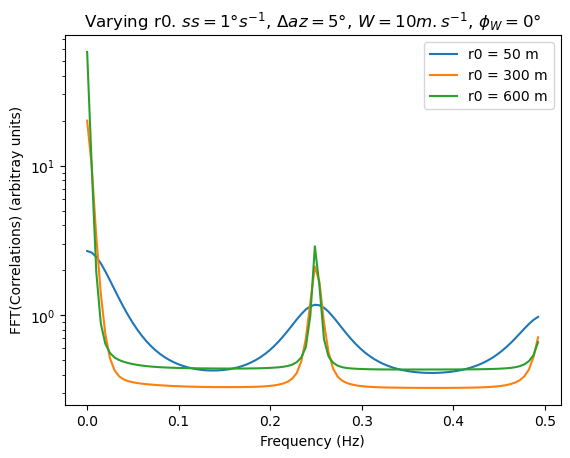

In [39]:
r0_list = [50, 300, 600]

for r0 in r0_list:
    corr = atm_correlations_gaussian_wind(h, h+3000, r_i=(0,0,1), ti=0, az_ti=azimuth_list[0], el_ti=np.radians(45), r_j=(0,0,1), 
                               tj=time_list, az_tj=azimuth_list, el_tj=np.radians(45), W=10, phi_W=phi_W, freq=150e9, n=8, r0=r0)[1]
    FFT_corr = np.fft.fft(corr).real
    plt.plot(np.fft.fftfreq(201, 1)[:100], FFT_corr[:100]/FFT_corr[100], label='r0 = '+str(r0)+' m')

plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT(Correlations) (arbitray units)')
plt.yscale('log')
plt.title('Varying r0. '+r'$ss = 1°s^{-1},\, \Delta az = 5°,\, W = 10 m.s^{-1},\, \phi_W = 0°$')
plt.legend()
plt.show()

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


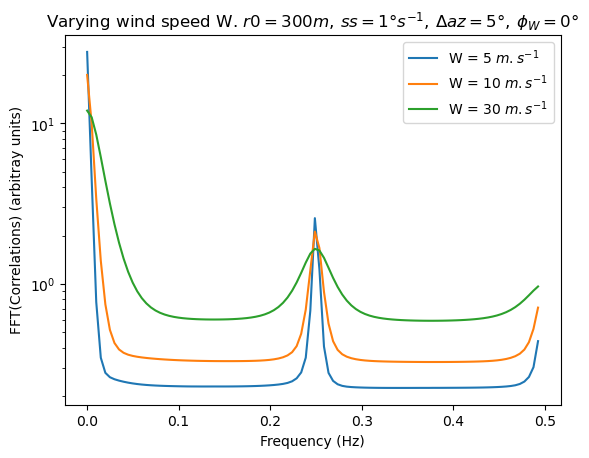

In [40]:
W_list = [5, 10, 30]

for Wind in W_list:
    corr = atm_correlations_gaussian_wind(h, h+3000, r_i=(0,0,1), ti=0, az_ti=azimuth_list[0], el_ti=np.radians(45), r_j=(0,0,1), 
                               tj=time_list, az_tj=azimuth_list, el_tj=np.radians(45), W=Wind, phi_W=phi_W, freq=150e9, n=8, r0=300)[1]
    FFT_corr = np.fft.fft(corr).real
    plt.plot(np.fft.fftfreq(201, 1)[:100], FFT_corr[:100]/FFT_corr[100], label='W = '+str(Wind)+r' $m.s^{-1}$')

plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT(Correlations) (arbitray units)')
plt.yscale('log')
plt.title('Varying wind speed W. '+r'$r0 = 300 m,\, ss = 1°s^{-1},\, \Delta az = 5°,\, \phi_W = 0°$')
plt.legend()
plt.show()

/tmp/ipykernel_20252/3635737774.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.where(r==0, 1, 2**(2/3)/sci_spe.gamma(1/3)*(r/r0)**(1/3)*sci_spe.kv(1/3, r/r0))


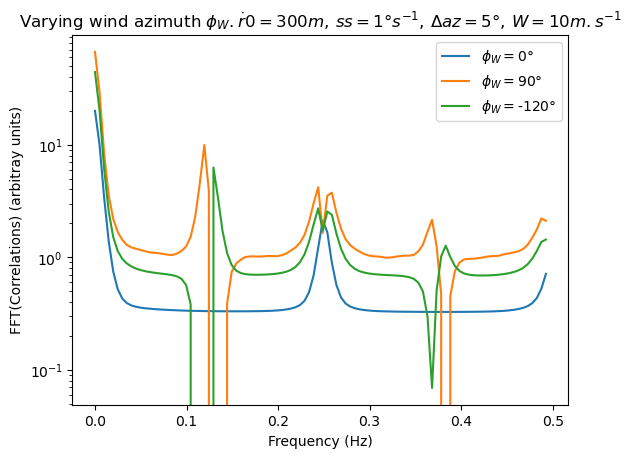

In [41]:
phi_W_list = [0, 90, -120]

for phi_Wind in phi_W_list:
    corr = atm_correlations_gaussian_wind(h, h+3000, r_i=(0,0,1), ti=0, az_ti=azimuth_list[0], el_ti=np.radians(45), r_j=(0,0,1), 
                               tj=time_list, az_tj=azimuth_list, el_tj=np.radians(45), W=10, phi_W=np.radians(phi_Wind), freq=150e9, n=8, r0=300)[1]
    FFT_corr = np.fft.fft(corr).real
    plt.plot(np.fft.fftfreq(201, 1)[:100], FFT_corr[:100]/FFT_corr[100], label=r'$\phi_W =$'+str(phi_Wind)+'°')

plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT(Correlations) (arbitray units)')
plt.yscale('log')
plt.title('Varying wind azimuth '+r'$\phi_W.\. r0 = 300 m,\, ss = 1°s^{-1},\, \Delta az = 5°,\, W = 10 m.s^{-1}$')
plt.legend()
plt.show()

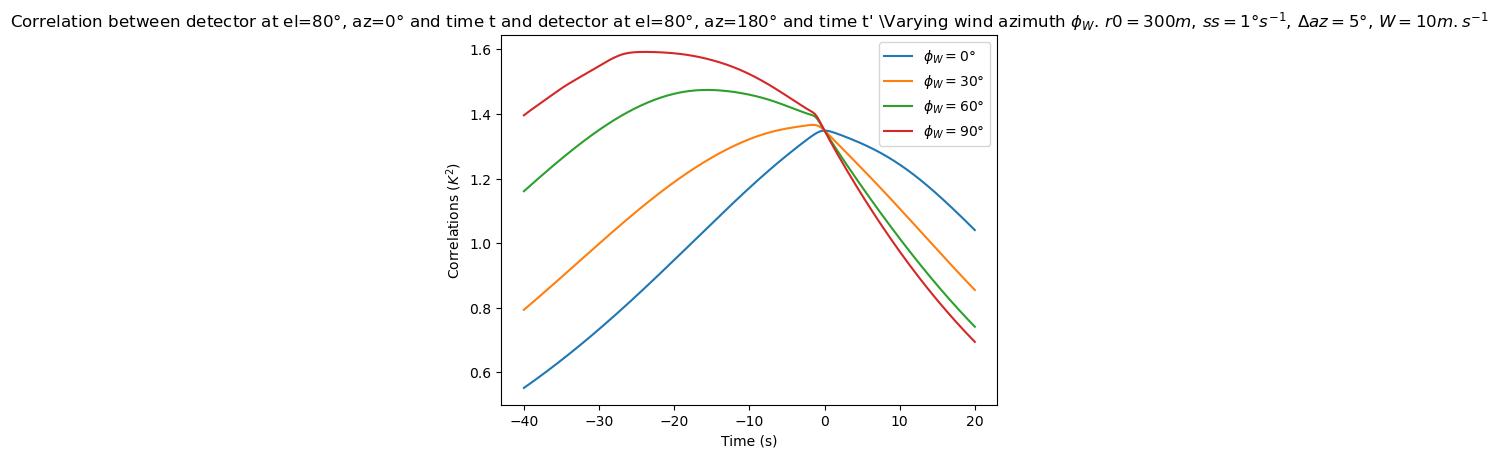

In [42]:
time_list = np.linspace(-40, 20, 201)
phi_W_list = [0, 30, 60, 90]

for phi_Wind in phi_W_list:
    corr = atm_correlations_gaussian_wind(h, h+3000, r_i=(-np.sin(np.radians(10)),0,np.cos(np.radians(10))), 
                                                   ti=0, az_ti=0, el_ti=np.radians(45), 
                                                   r_j=(np.sin(np.radians(10)),0,np.cos(np.radians(10))), 
                               tj=time_list, az_tj=0, el_tj=np.radians(45), W=10, phi_W=np.radians(phi_Wind), freq=150e9, n=8, r0=300)[1]
    plt.plot(time_list, corr, label=r'$\phi_W =$'+str(phi_Wind)+'°')

plt.xlabel('Time (s)')
plt.ylabel('Correlations '+r'$(K^2)$')
plt.title('Correlation between detector at el=80°, az=0° and time t and detector at el=80°, az=180° and time t\' \\'+
'Varying wind azimuth '+r'$\phi_W.\, r0 = 300 m,\, ss = 1°s^{-1},\, \Delta az = 5°,\, W = 10 m.s^{-1}$')
plt.legend()
plt.show()

# Temperature

In [43]:
N = 10000
L = 2800

In [44]:
# We will use the Kolomogorov power spectrum to simulate turbulences in atmosphere
def kolmogorov_spectra_2d(k):
    return (maximum_length**(-2) + np.abs(k)**2)**(-8/6)

# We normalize to have the integral of the power spectrum over all k egal to 1
res, _ = scipy.integrate.quad(kolmogorov_spectra_2d, np.min(k_mag), np.max(k_mag))
def normalized_kolmogorov_2d(k):  
    return kolmogorov_spectra_2d(k)/res

In [45]:
# Generate spatial frequency in Fourier space
k_distrib = np.fft.fftfreq(N, d=2*L/N) * 2*np.pi
kx, ky = np.meshgrid(k_distrib, k_distrib)
k_mag = np.sqrt(kx**2 + ky**2)

In [46]:
# Compute the Kolmogorov power spectrum 
P_k = normalized_kolmogorov_2d(k_mag)

# Generate spatial fluctuations using the spatial power spectrum
phi = np.random.uniform(0, 2*np.pi, size=(N, N))
delta_rho_k = np.sqrt(P_k) * np.exp(1j * phi)

# Apply inverse Fourier transform to obtain spatial fluctuations
delta_rho = np.fft.ifft2(delta_rho_k).real

In [47]:
PWV = 5 #mm^-1
z = np.linspace(h, h+Lz, N)
mean_water_vapor = water_vapor_density(h + Lz)
sigma_PWV = 0.5 #mm^-1
sigma_rho = sigma_PWV / 3 * mean_water_vapor

# Takes into account the cutoff of high wavenumbers
sigma_simulated = sigma_rho * np.sqrt(scipy.integrate.quad(lambda k : kolmogorov_spectra_2d(k) * k**2, np.min(k_distrib), np.max(k_distrib))[0] 
                                       / scipy.integrate.quad(lambda k : kolmogorov_spectra_2d(k) * k**2, -maximum_length, maximum_length)[0])

rho_2d = np.zeros((N, N))

mean_delta = np.mean(delta_rho)
var_delta = np.var(delta_rho)

rho_2d += mean_water_vapor + sigma_simulated * (delta_rho - mean_delta) / np.sqrt(var_delta)

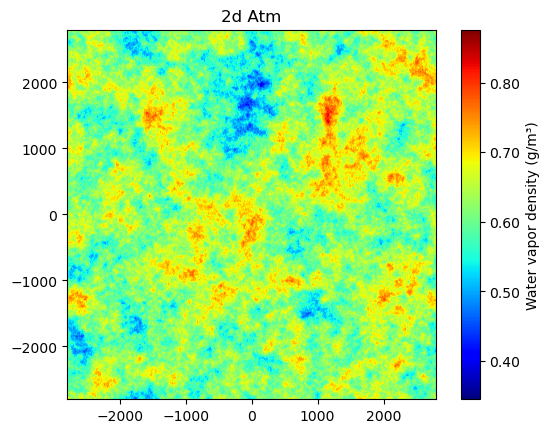

In [48]:
plt.figure()
plt.imshow(rho_2d, extent=[-L, L, -L, L], cmap='jet')
plt.title('2d Atm')
plt.colorbar(format = '%.2f', label = 'Water vapor density (g/m³)')
plt.show()

In [49]:
def azel_to_horizontal_plane(az, el, h):
    x = h / np.sin(el) * np.cos(el) * np.cos(az)
    y = h / np.sin(el) * np.cos(el) * np.sin(az)
    return x, y

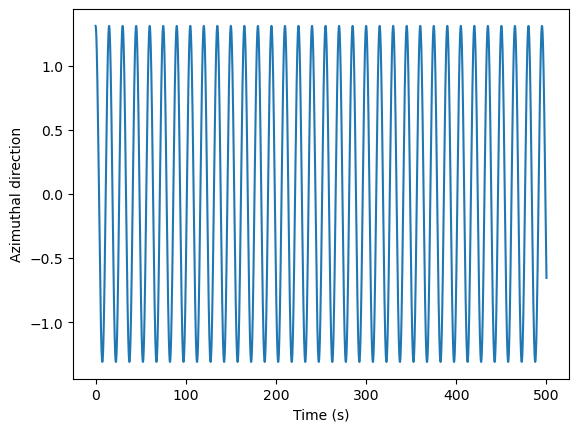

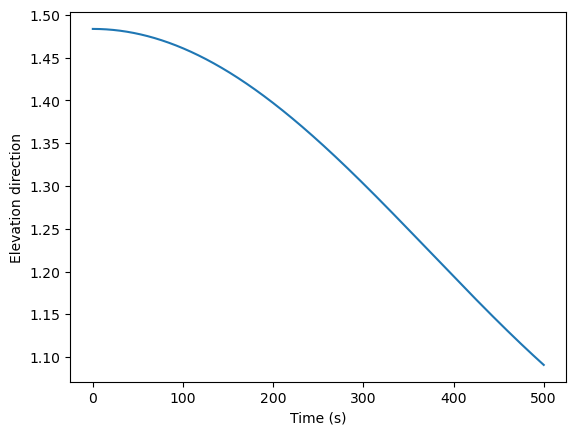

In [50]:
#Simulation parameters

W = 0                        # Speed of the wind (m s^-1)
phi_W = 0                    # Azimuth of the wind (rad)
elevation_ini = np.radians(70)
delta_az = np.radians(150)     # Angular size of the scan in the azimuth direction (rad)
delta_el = np.radians(30)
ss_az = np.radians(10)           # Scanning speed (rad s^-1)
ss_el = np.radians(0.02)
f_scan_az = ss_az/(delta_az)      # Scan frequency (Hz)
f_scan_el = ss_el/delta_el

time_list = np.linspace(0, 500, 50000)
azimuth_list = delta_az / 2 * np.cos(2*np.pi * f_scan_az * time_list)
elevation_list = delta_el / 2 * np.cos(2*np.pi * f_scan_el * time_list) + elevation_ini * np.ones(len(time_list))

plt.plot(time_list, azimuth_list)
plt.xlabel('Time (s)')
plt.ylabel('Azimuthal direction')
plt.show()

plt.plot(time_list, elevation_list)
plt.xlabel('Time (s)')
plt.ylabel('Elevation direction')
plt.show()

In [51]:
x_list, y_list = azel_to_horizontal_plane(azimuth_list, elevation_list, h)

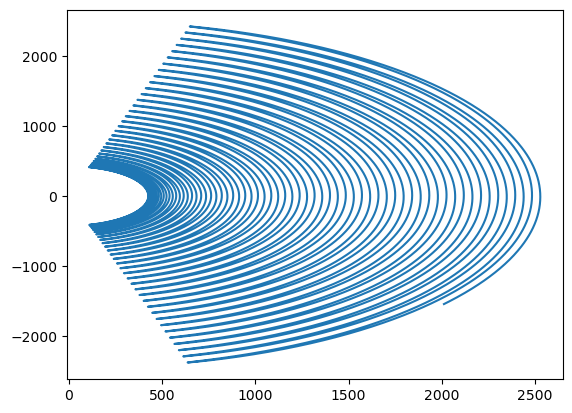

In [52]:
plt.plot(x_list, y_list)

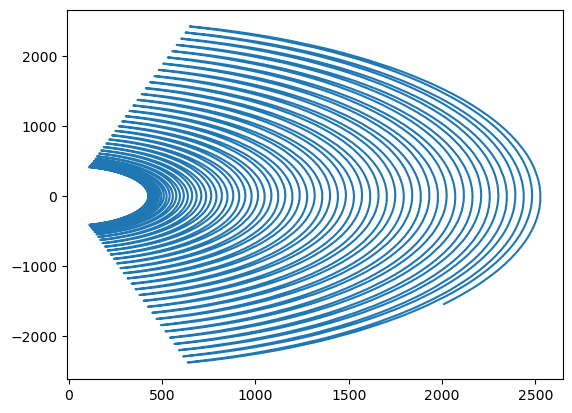

In [53]:
x_round = x_list.round()
y_round = y_list.round()
plt.plot(x_round, y_round)

In [54]:
def find_closest_element(arr, variable):
    idx = np.abs(arr - variable).argmin()
    return idx, arr[idx]

# Example usage:
my_array = np.linspace(0, 10, 100)
variable = 6
closest_number = find_closest_element(my_array, variable)
print("Closest number:", closest_number)

Closest number: (59, 5.959595959595959)


In [55]:
def get_atm_value_2d(rho_2d, az, el, x, y, height):
    x_atm, y_atm = azel_to_horizontal_plane(az, el, height)
    ind_x, x_pos = find_closest_element(x, x_atm)
    ind_y, y_pos = find_closest_element(y, y_atm)
    return x_pos, y_pos, rho_2d[ind_y, ind_x]

def get_norm(z1, z2):
    # Determine the range for normalization
    vmin = min(np.min(z1), np.min(z2))
    vmax = max(np.max(z1), np.max(z2))
    # Create the normalization instance
    return Normalize(vmin=vmin, vmax=vmax)

In [56]:
x = np.linspace(-L, L, N)
y = np.linspace(-L, L, N)
def atm_contrib_raw(rho_2d, az, el, height, freq):
    x_pos, y_pos, rho_atm = get_atm_value_2d(rho_2d, az, el, x, y, height)
    return x_pos, y_pos, rho_atm #* molecular_absorption_coeff * atm_temp(height)

In [57]:
temp_raw = []
x_raw, y_raw = [], []
for i in range(len(azimuth_list)):
    x_atm, y_atm, temp_atm = atm_contrib_raw(rho_2d, azimuth_list[i], elevation_list[i], h, 150*10e9)
    x_raw.append(x_atm)
    y_raw.append(y_atm)
    temp_raw.append(temp_atm)

Text(0, 0.5, '')

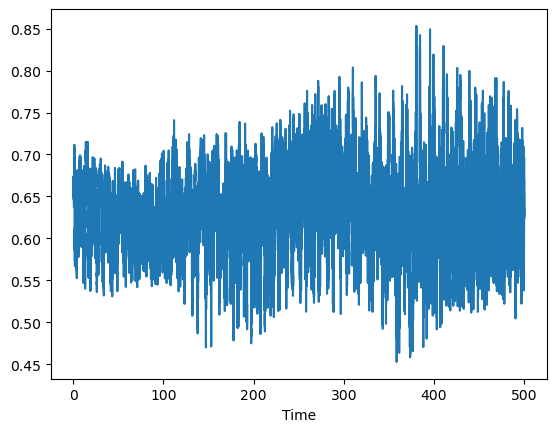

In [58]:
plt.plot(time_list, temp_raw)
plt.xlabel('Time')
plt.ylabel('')

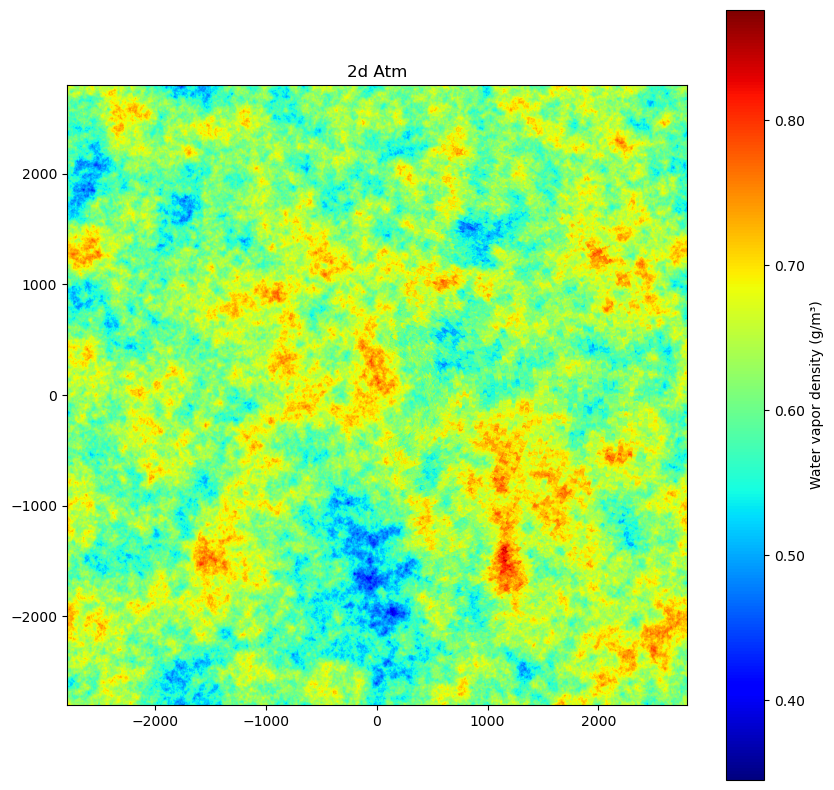

In [59]:
plt.figure(figsize=(10, 10))
norm = get_norm(rho_2d, temp_raw)
plt.scatter(x_raw, y_raw, s = 2, c=temp_raw, cmap='jet', norm=norm)
plt.imshow(rho_2d, extent=[-L, L, -L, L], cmap='jet', origin='lower', norm=norm)
plt.title('2d Atm')
plt.colorbar(format = '%.2f', label = 'Water vapor density (g/m³)')

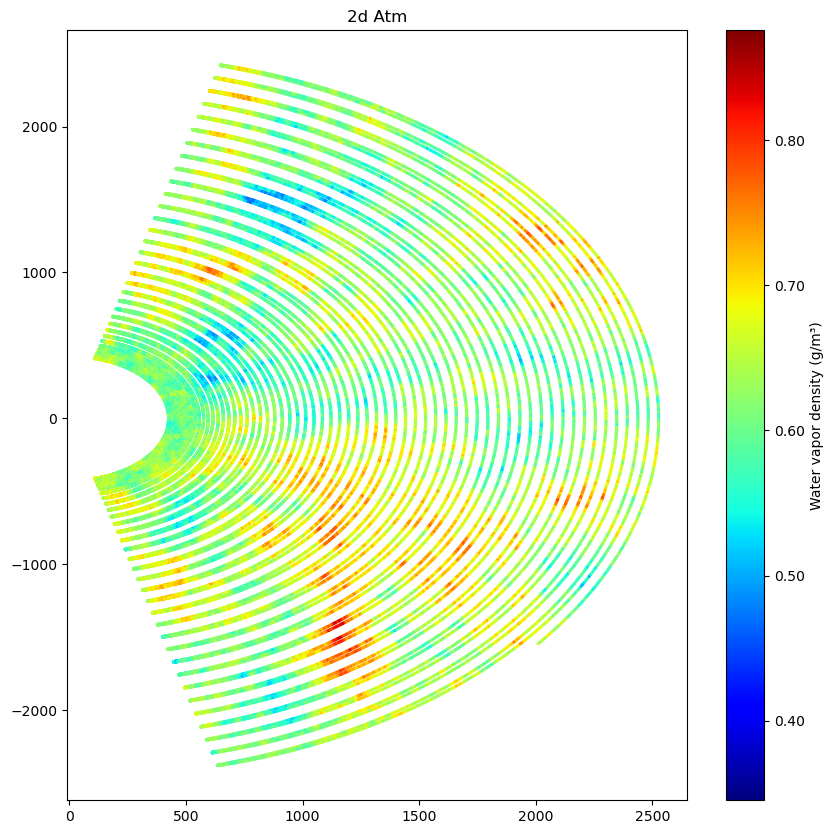

In [60]:
plt.figure(figsize=(10, 10))
norm = get_norm(rho_2d, temp_raw)
plt.scatter(x_raw, y_raw, s=2, c=temp_raw, cmap='jet', norm=norm)
plt.title('2d Atm')
plt.colorbar(format = '%.2f', label = 'Water vapor density (g/m³)')

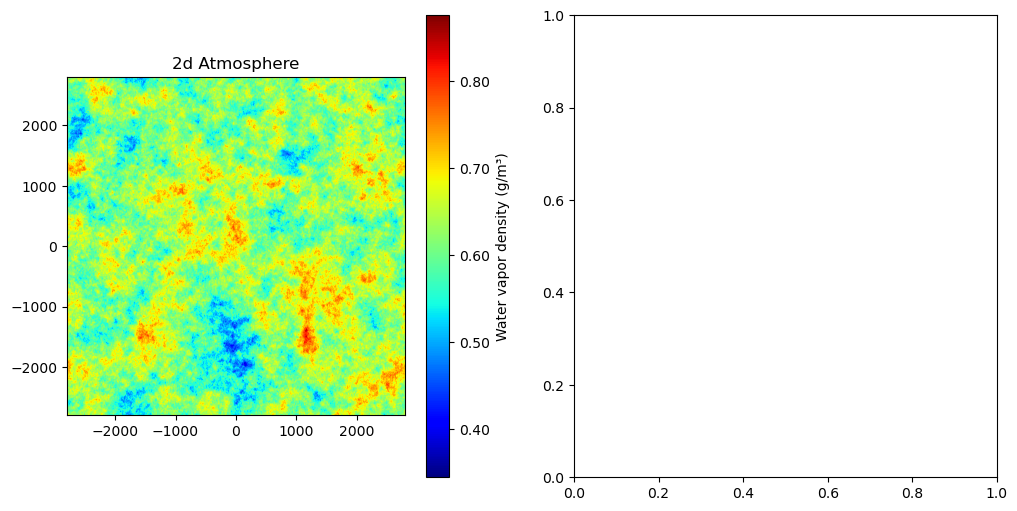

In [61]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

norm = get_norm(rho_2d, temp_raw)

im = axs[0].imshow(rho_2d, cmap='jet', norm=norm, origin='lower', extent=[-L, L, -L, L])
axs[0].set_title('2d Atmosphere')
fig.colorbar(im, format = '%.2f', label = 'Water vapor density (g/m³)', ax=axs[0])

def update(frame):
    idx_frame = 100*frame
    axs[1].cla()
    axs[1].scatter(x_raw[:idx_frame], y_raw[:idx_frame], s = 2, c=temp_raw[:idx_frame], cmap='jet', norm=norm)
    axs[1].set_xlim(-L, L)
    axs[1].set_ylim(-L, L)
    axs[1].set_title('Scanning {}'.format(frame))

# ani = FuncAnimation(fig, update, frames=range(int(len(temp_raw)/100)), interval=25)
# html_video = HTML(ani.to_html5_video())
# display(html_video)


# MM of the atm

# QUBIC’s beam

## Simulation parameters

In [62]:
theta_FWHM_QUBIC = np.radians(12.9)
P = 20
delta_h = 14e-3  

/tmp/ipykernel_20252/1384559387.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_list = [scipy.integrate.quad(lambda x: int_beam_qubic(x, freq), -np.inf, np.inf)[0] for freq in freq_list]


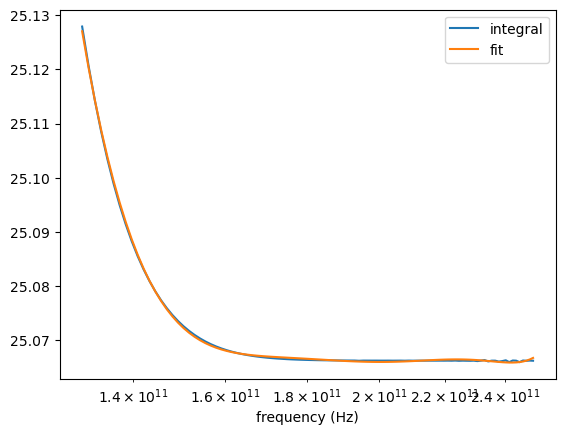

In [63]:
def int_beam_qubic(x, freq):
    '''
    integrand of qubic's beam
    '''
    wavelength = scipy.constants.c / freq
    sin2_P = np.sin(P * np.pi * delta_h/wavelength * theta_FWHM_QUBIC/np.sqrt(2*np.log(2)) * x)**2
    sin2 = np.sin(np.pi * delta_h/wavelength * theta_FWHM_QUBIC/np.sqrt(2*np.log(2)) * x)**2
    return np.exp(-2 * x**2) * sin2_P / sin2

freq_list = np.linspace(130e9, 250e9, 100)
integral_list = [scipy.integrate.quad(lambda x: int_beam_qubic(x, freq), -np.inf, np.inf)[0] for freq in freq_list]

fit_parameters = np.polyfit(freq_list, integral_list, 6)
fit_list = np.polyval(fit_parameters, freq_list)

plt.plot(freq_list, integral_list, label='integral')
plt.plot(freq_list, fit_list, label='fit')
plt.xscale('log')
plt.xscale('log')
plt.xlabel('frequency (Hz)')
plt.legend()
plt.show()

In [64]:
def gaussian_envelope_qubic(z, freq):
    wavelength = scipy.constants.c / freq
    gaussian_beam_waist = wavelength / (np.pi * theta_FWHM_QUBIC) * np.sqrt(2 * np.log(2))
    return gaussian_beam_waist * np.sqrt(1 + (wavelength * z / (np.pi * gaussian_beam_waist**2))**2)

def qubic_beam_normalized(x, y, z, freq):
    wavelength = scipy.constants.c / freq
    wz = gaussian_envelope_qubic(z, freq)
    if x==0:
        sin2_P_x = P**2
        sin2_x = 1
    else:
        sin2_P_x = np.sin(P * np.pi * delta_h/wavelength * theta_FWHM_QUBIC/np.sqrt(2*np.log(2)) * x/wz)**2
        sin2_x = np.sin(np.pi * delta_h/wavelength * theta_FWHM_QUBIC/np.sqrt(2*np.log(2)) * x/wz)**2
    if y==0:
        sin2_P_y = P**2
        sin2_y = 1
    else:
        sin2_P_y = np.sin(P * np.pi * delta_h/wavelength * theta_FWHM_QUBIC/np.sqrt(2*np.log(2)) * y/wz)**2
        sin2_y = np.sin(np.pi * delta_h/wavelength * theta_FWHM_QUBIC/np.sqrt(2*np.log(2)) * y/wz)**2

    return 1/wz**2 * np.exp(-2 * (x**2 + y**2) /wz**2) * sin2_P_x / sin2_x * sin2_P_y / sin2_y / np.polyval(fit_parameters, freq)**2

#print(scipy.integrate.dblquad(lambda x,y: qubic_beam_normalized(x, y, 50, 150e9), -np.inf, np.inf, -np.inf, np.inf))

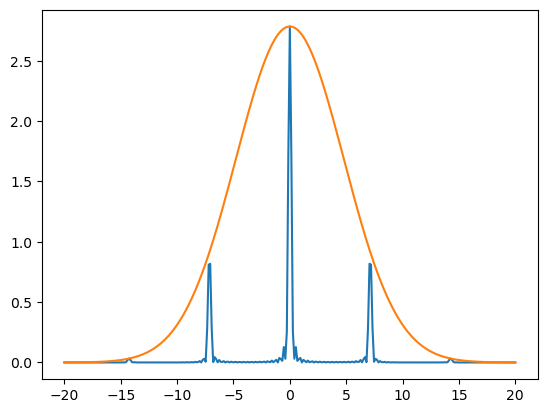

In [65]:
X = np.linspace(-20, 20, 301)
Beam = [qubic_beam_normalized(x, 0, 50, 150e9) for x in X]
wz = gaussian_envelope_qubic(50, 150e9)
plt.plot(X, Beam)
plt.plot(X, Beam[150] *np.exp(-2*(X/wz)**2))

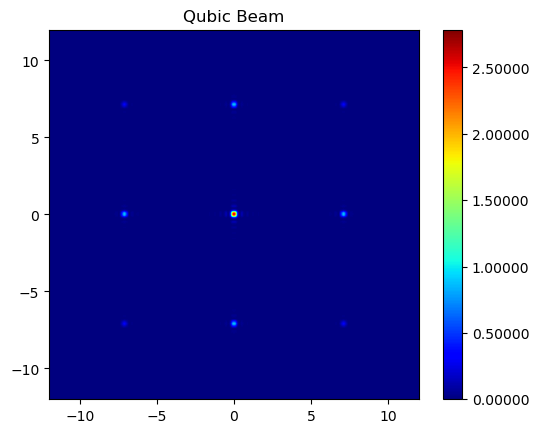

In [66]:
X = np.linspace(-12, 12, 301)
b = []
for y in X:
    l=[]
    for x in X:
        l.append(qubic_beam_normalized(x, y, 50, 150e9))
    b.append(l)

plt.figure()
plt.imshow(b, extent=[-12, 12, -12, 12], cmap='jet')
plt.title('Qubic Beam')
plt.colorbar(format = '%.5f')
plt.show()

In [67]:
def gaussian_beam_normalized_detector(r_i, x, y, z, freq):
    '''
    The integral on any surface of constant z is 1

    r_i is the normalized vector of the direction of detector i. For the central detector it is (0,0,1)
    x, y, z coordinates in the sky
    '''
    wavelength = scipy.constants.c / freq
    scalar = np.dot(r_i, (x,y,z))
    wz = gaussian_beam_width(scalar, freq)
    return 2 / (np.pi * wz**2) * np.exp(- 2 * (x**2 + y**2 + z**2 - scalar**2) / wz**2)

In [68]:
print(scipy.integrate.dblquad(lambda x,y: qubic_beam_normalized(x, y, 50, 150e9), -15, 15, -15, 15))

(0.9996490670043591, 2.3117361357106146e-08)


$$w(z)=w_0\sqrt{1+\left(\frac{\lambda z}{\pi w_0^2}\right)^2}$$
$$B_g(z,r)=\frac{2}{\pi w(z)^2}\exp \left(-2\frac{r^2}{w(z)^2}\right)$$
$$T_{atm}=T_0\left(1-\frac{h}{h_{atm}}\right)$$
$$\langle \rho(h)\rangle = \rho_0 \exp\left(-\log(2) \frac{h-5190}{h_0}\right)$$
$$C_{ij}=\alpha_b(\nu)^2\iiint \iiint D(r_{ij}) \langle\rho(h_i)\rangle \langle\rho(h_j)\rangle T_{atm}(h_i) T_{atm}(h_j) B_{n, i}(\vec{r}_i, x_i, y_i, z_i, \nu) B_{n, j}(\vec{r}_j, x_j, y_j, z_j, \nu) dx_i dy_i dz_i dx_j dy_j dz_j$$

